In [1]:
!pip install umap-learn

     ---------------------------------------- 88.2/88.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached numba-0.57.0-cp310-cp310-win_amd64.whl (2.6 MB)
     ---------------------------------------- 1.1/1.1 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached llvmlite-0.40.0-cp310-cp310-win_amd64.whl (27.7 MB)
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82909 sha256=a7c949d5c1a1a736adcb55a81d275dd183abc4cc180cffc7ce15c0783f400618
  Stored in directory: c:\users\rusla\appdata\local\pip\cache\wheels\73\d4\20\721044c5f3d1ab1c08a9d6d200964f2543974496570117e59b
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55676 sha256=6ef6409446db2226ba9af51cbc0a7c51ee2bd9546a7412ee34ea3f722394acec
  Stored


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

In [7]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

def fit_predict(algorithm, m_X):
    labels = algorithm.fit_predict(m_X)

    ari = adjusted_rand_score(iris.target, labels)

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    silhouette = np.nan if n_clusters_ <= 1 else silhouette_score(m_X, labels)

    return labels, ari, silhouette

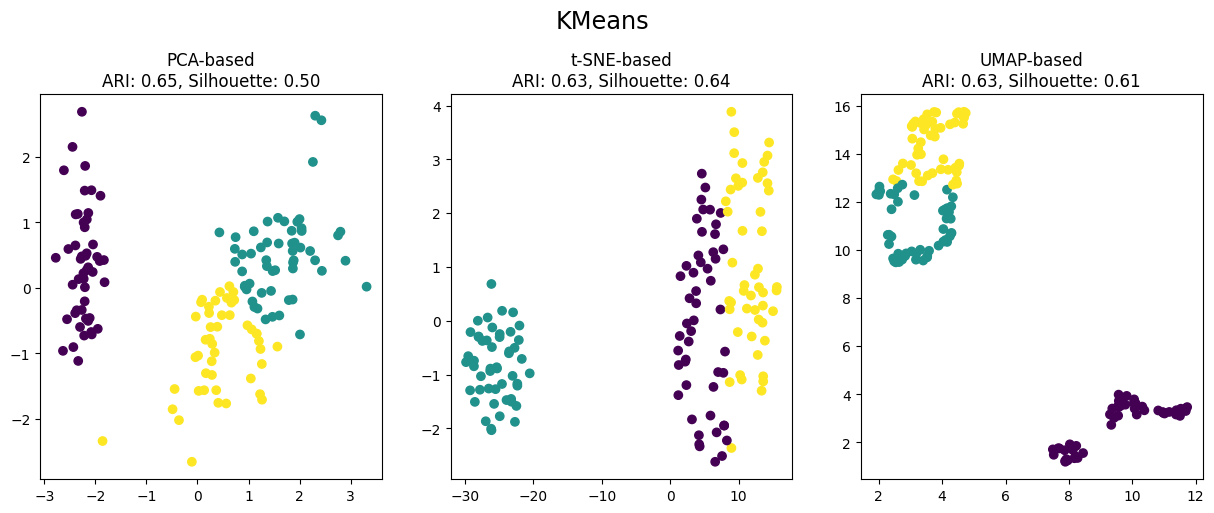

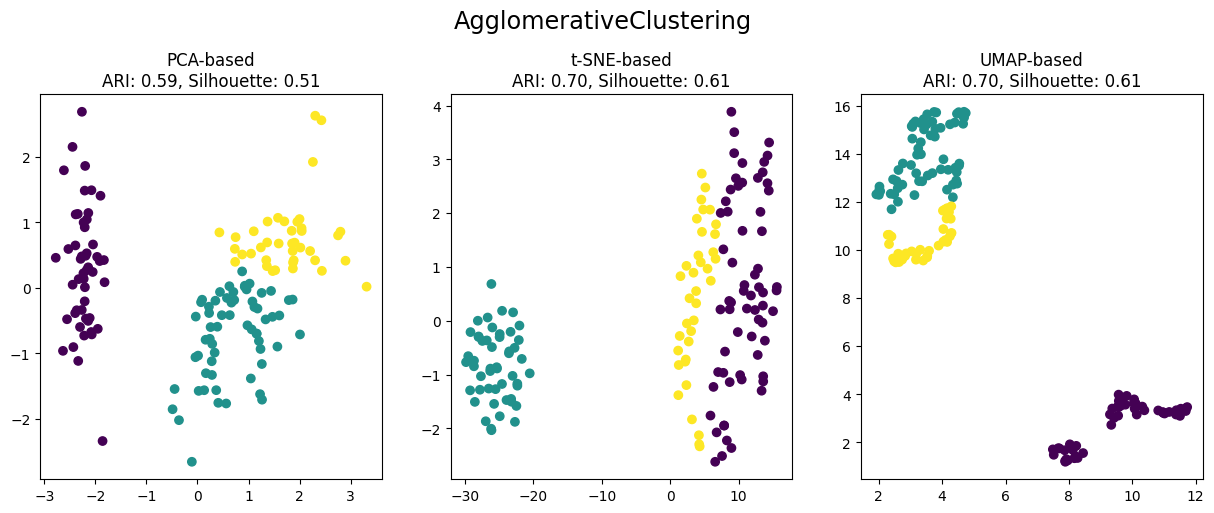

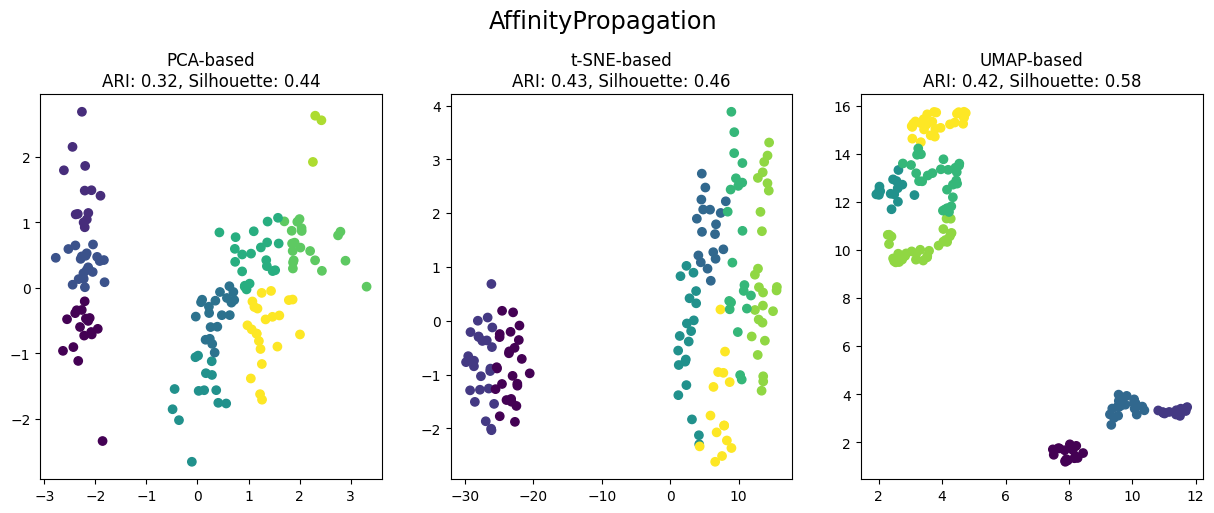

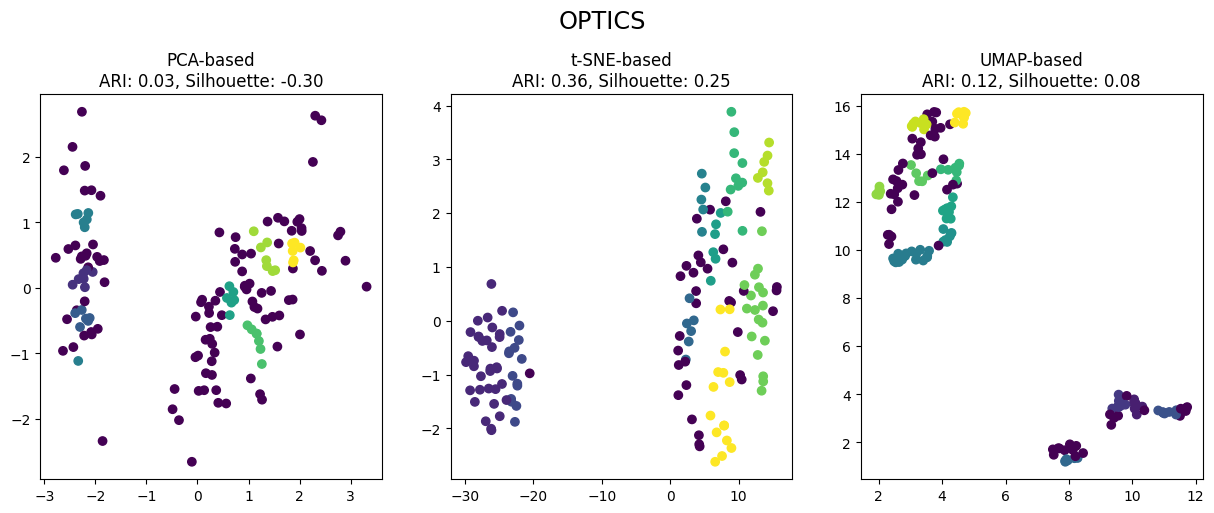

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch, SpectralClustering, MiniBatchKMeans, MeanShift, AffinityPropagation, OPTICS

import os

# KMeans AffinityPropagation AgglomerativeClustering OPTICS

clustering_algorithms = [
    KMeans(n_clusters=3, n_init='auto'),
    AgglomerativeClustering(n_clusters=3),
    AffinityPropagation(),
    OPTICS(),
]

def get_clustering(m_clustering_algorithms, filename):
  for algorithm in m_clustering_algorithms:
      pca_labels, pca_ari, pca_silhouette = fit_predict(algorithm, X_pca)

      tsne_labels, tsne_ari, tsne_silhouette = fit_predict(algorithm, X_tsne)

      umap_labels, umap_ari, umap_silhouette = fit_predict(algorithm, X_umap)

      fig, axs = plt.subplots(1, 3, figsize=(15, 5))

      axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=pca_labels)
      axs[0].set_title(f'PCA-based\nARI: {pca_ari:.2f}, Silhouette: {pca_silhouette:.2f}')

      axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=tsne_labels)
      axs[1].set_title(f't-SNE-based\nARI: {tsne_ari:.2f}, Silhouette: {tsne_silhouette:.2f}')

      axs[2].scatter(X_umap[:, 0], X_umap[:, 1], c=umap_labels)
      axs[2].set_title(f'UMAP-based\nARI: {umap_ari:.2f}, Silhouette: {umap_silhouette:.2f}')

      algorithm_name = algorithm.__class__.__name__
      plt.suptitle(algorithm_name, y=1.05, fontsize='xx-large')

      os.makedirs('clusters', exist_ok=True)
      plt.savefig(f'clusters/{algorithm}-{filename}.png')

      plt.show()
  
get_clustering(clustering_algorithms, 'default')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import DBSCAN, MeanShift, AffinityPropagation, AgglomerativeClustering, Birch, SpectralClustering, OPTICS
import os
import itertools
import seaborn as sns

AgglomerativeClusteringConsts = {'n_clusters': None}

algorithms = [
    ('KMeans', 
      KMeans, 
      {'n_clusters': range(1, 100, 10), 'init': ['k-means++', 'random']}, 
      {'n_init': 'auto'}
    ),
    ('AffinityPropagation', 
      AffinityPropagation, 
      {'damping': np.linspace(0.5, 0.9999, 10)}, 
      {}
    ),
    ('AgglomerativeClustering', 
      AgglomerativeClustering, 
      {'linkage': ['ward', 'complete', 'average', 'single'], 
       'distance_threshold': [0.1, 0.5, 1.0, 2.0]}, 
      AgglomerativeClusteringConsts
    ),
    ('AgglomerativeClustering', 
      AgglomerativeClustering, 
      {
       'linkage': ['ward', 'complete', 'average', 'single'], 
       'n_clusters': range(1, 100, 10)
      },
      {}
    ),
    ('OPTICS',
      OPTICS, 
      {'min_samples': range(1, 10),
       'max_eps': np.linspace(4.0, 6.0, 10)},
      {}
    )
]

def compare(values):
  for i, (algorithm_name, algorithm, hyperparams, consts) in enumerate(algorithms):
      print(f'Processing {algorithm_name}')

      fig, ax = plt.subplots(1, 3, figsize=(30, 10))

      param_names = hyperparams.keys()
      param_values = hyperparams.values()
      
      combinations = list(itertools.product(*param_values))
      
      if len(param_names) == 1:
          aris = []
          n_clusters_arr = []
          silhouettes = []

          for combination in combinations:
              hyperparams_comb = dict(zip(param_names, combination))

              # labels = algorithm(**hyperparams_comb, **consts).fit_predict(values)
              labels, ari, silhouette = fit_predict(algorithm(**hyperparams_comb, **consts), values)
              
              n_clusters = len(np.unique(labels))

              n_clusters_arr.append(n_clusters)
              aris.append(ari)
              silhouettes.append(silhouette)

              ax[0].scatter(combination[0], n_clusters, c='blue', s=30)
              ax[1].scatter(combination[0], ari, c='green', s=30)
              ax[2].scatter(combination[0], silhouette, c='red', s=30)

          plt.suptitle(f'{algorithm_name}')
          ax[0].plot(combinations, n_clusters_arr, c='blue')
          ax[0].set_ylabel('Number of Clusters')

          ax[1].plot(combinations, aris, c='green')
          ax[1].set_ylabel('Ari')

          ax[2].plot(combinations, silhouettes, c='red')
          ax[2].set_ylabel('Silhouette')

          for j in range(0, 3):
            ax[j].set_xlabel(list(param_names)[0])
            ax[j].grid(True)

      elif len(param_names) == 2:
          param1_values = list(hyperparams.values())[0]
          param2_values = list(hyperparams.values())[1]

          heatmap_clusters = np.zeros((len(param1_values), len(param2_values)))
          heatmap_ari = np.zeros((len(param1_values), len(param2_values)))
          heatmap_silhouette = np.zeros((len(param1_values), len(param2_values)))

          for combination in combinations:
              hyperparams_comb = dict(zip(param_names, combination))
              
              # labels = algorithm(**hyperparams_comb, **consts).fit_predict(values)
              labels, ari, silhouette = fit_predict(algorithm(**hyperparams_comb, **consts), values)

              n_clusters = len(np.unique(labels))

              param1_index = np.where(np.array(param1_values) == combination[0])[0][0]
              param2_index = np.where(np.array(param2_values) == combination[1])[0][0]

              heatmap_clusters[param1_index, param2_index] = n_clusters
              heatmap_ari[param1_index, param2_index] = ari
              heatmap_silhouette[param1_index, param2_index] = silhouette

          ylabels = [f'{x:,.2f}' if isinstance(x, float) else str(x) for x in param2_values]
          xlabels = [f'{x:,.2f}' if isinstance(x, float) else str(x) for x in param1_values]


          sns.heatmap(heatmap_clusters.T, cmap='viridis', ax=ax[0], cbar=True, annot=True, fmt=".0f",  xticklabels=xlabels, yticklabels=ylabels)
          ax[0].set_title(f'{algorithm_name} - Number of Clusters Heatmap')

          sns.heatmap(heatmap_ari.T, cmap='viridis', ax=ax[1], cbar=True, annot=True, fmt=".3g",  xticklabels=xlabels, yticklabels=ylabels)
          ax[1].set_title(f'{algorithm_name} - Ari')

          sns.heatmap(heatmap_silhouette.T, cmap='viridis', ax=ax[2], cbar=True, annot=True, fmt=".3g",  xticklabels=xlabels, yticklabels=ylabels)
          ax[2].set_title(f'{algorithm_name} - Silhouette')

          for j in range(0, 3):
            ax[j].invert_yaxis()
            ax[j].set_xlabel(list(param_names)[0])
            ax[j].set_ylabel(list(param_names)[1])

      else:
          print(f'Invalid number of parameters for {algorithm_name}')

      plt.show()

Нарисуем зависимость количества кластеров от гиперпармаетров для данных спроецированных с помощью PCA

UPD: лучшие гиперпараметры
- KMeans - init=k-means++, n_clusters=21 
- AffinityPropagation - damping=0.5
- AgglomerativeClustering - linkage=single, distance_threshold=1.00, n_clusters=None
- AgglomerativeClustering - n_clusters=10, linakge=average
- OPTICS - max_eps=5.00, min_samples=6
- Birch - threshold=1.40, branching_factor=40
- Birch - branching_factor=40, n_clusters=11

Processing KMeans


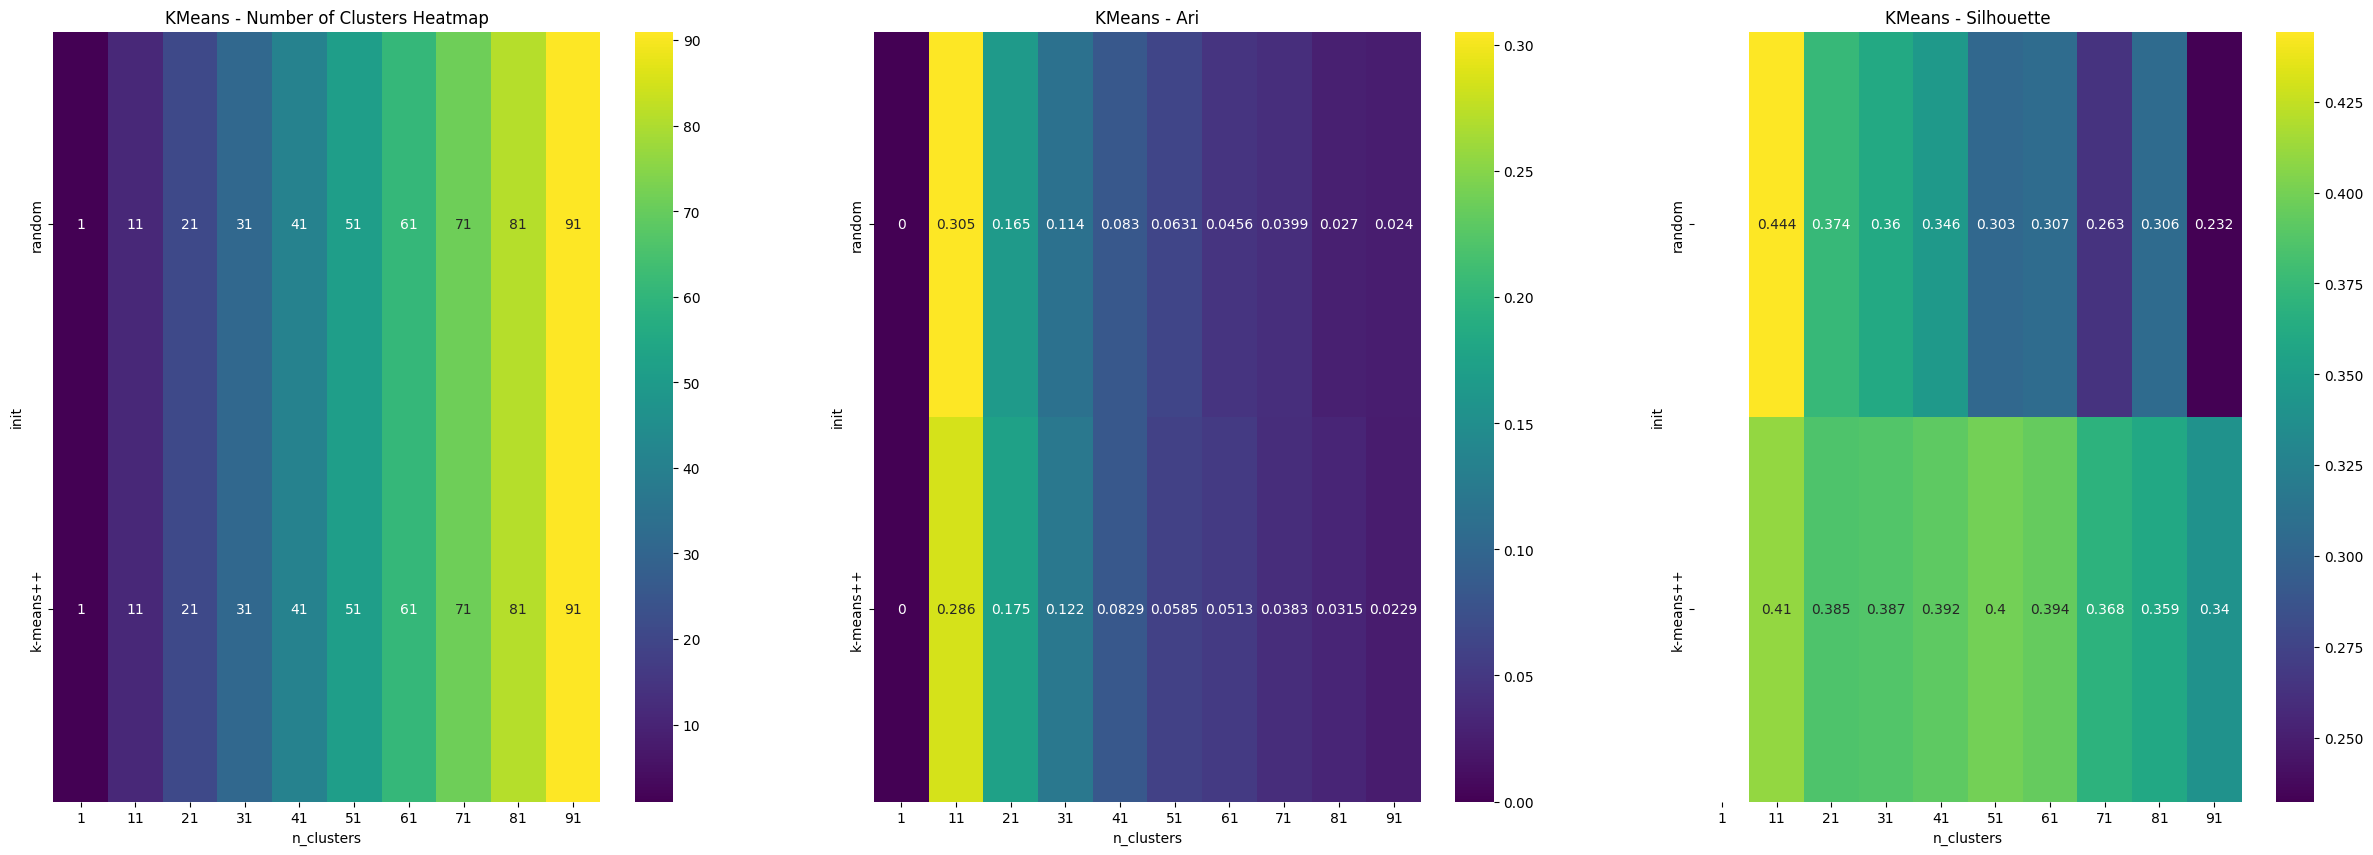

Processing AffinityPropagation


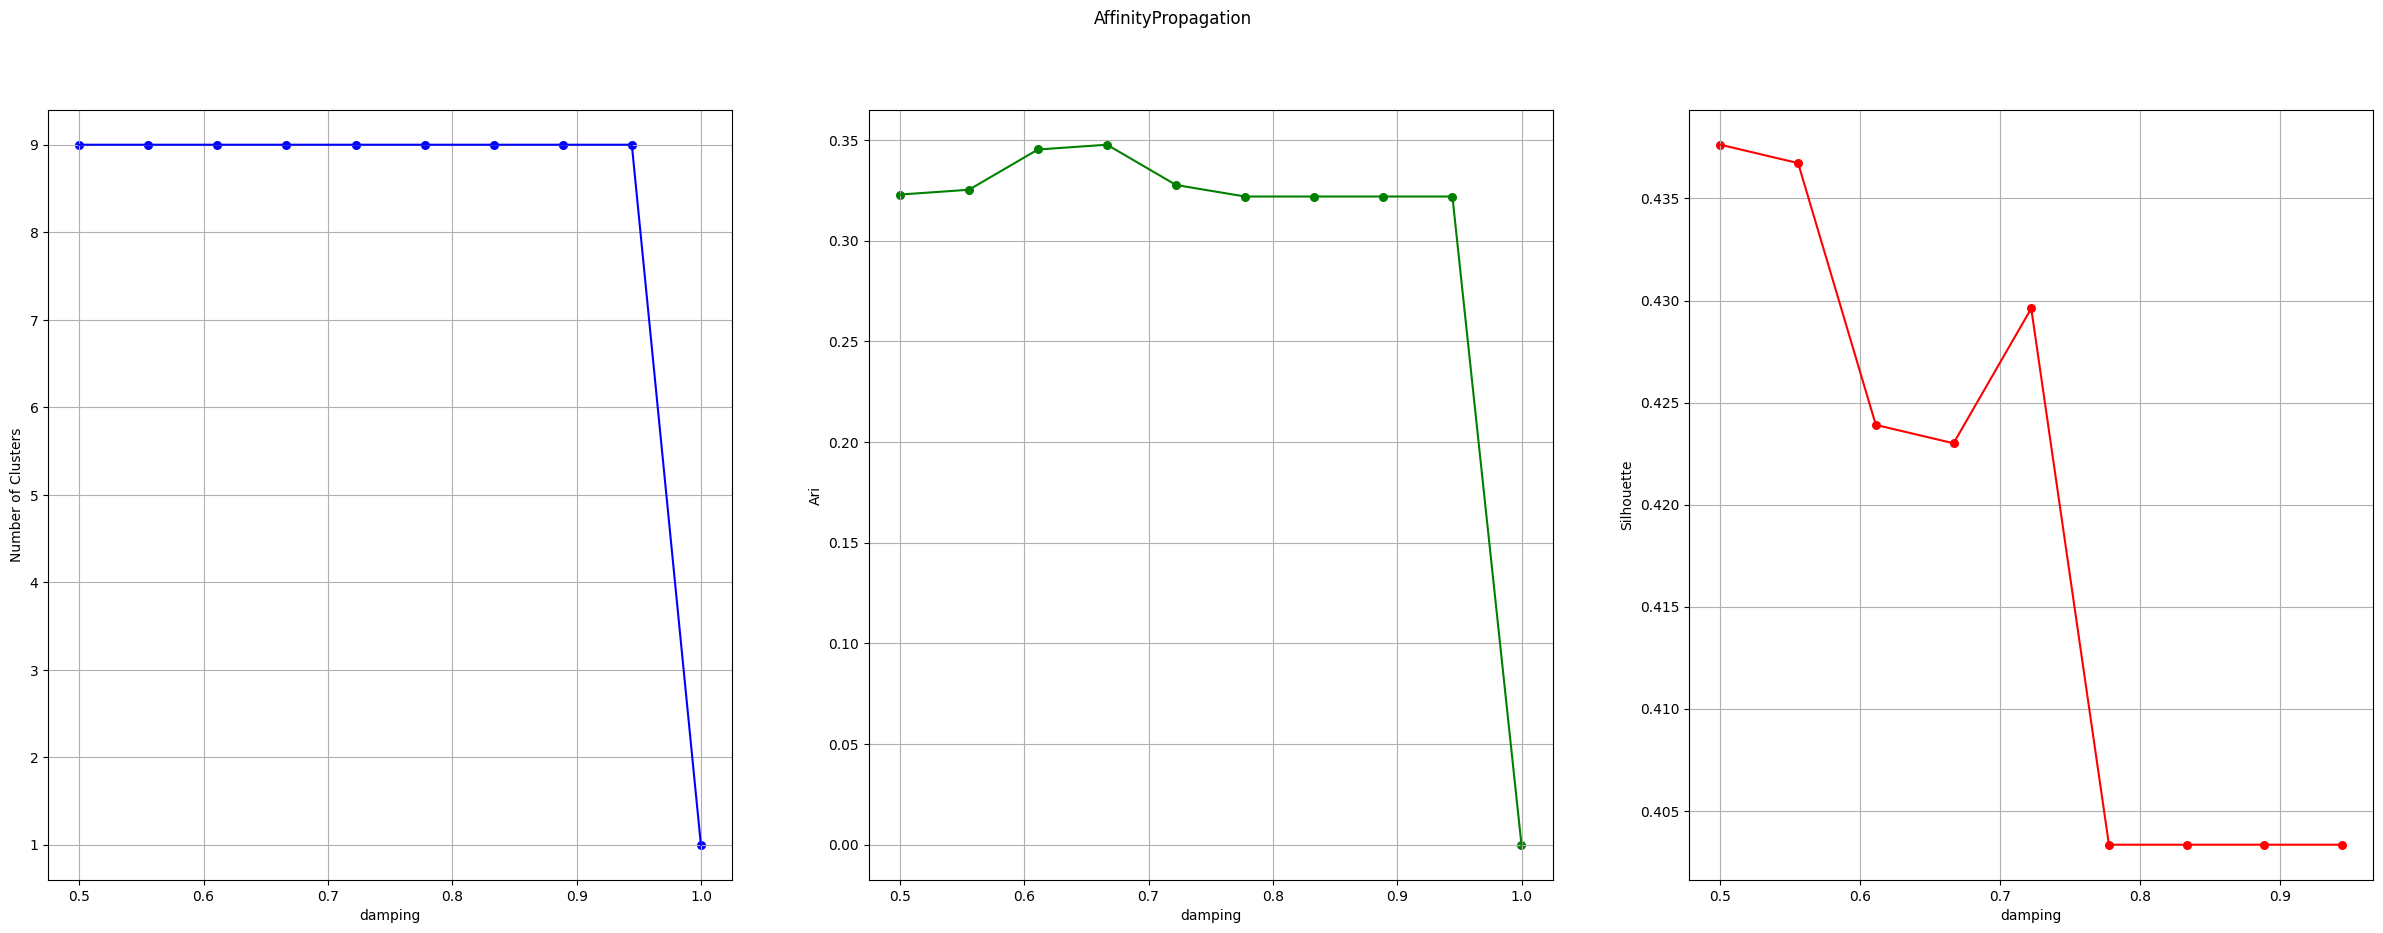

Processing AgglomerativeClustering


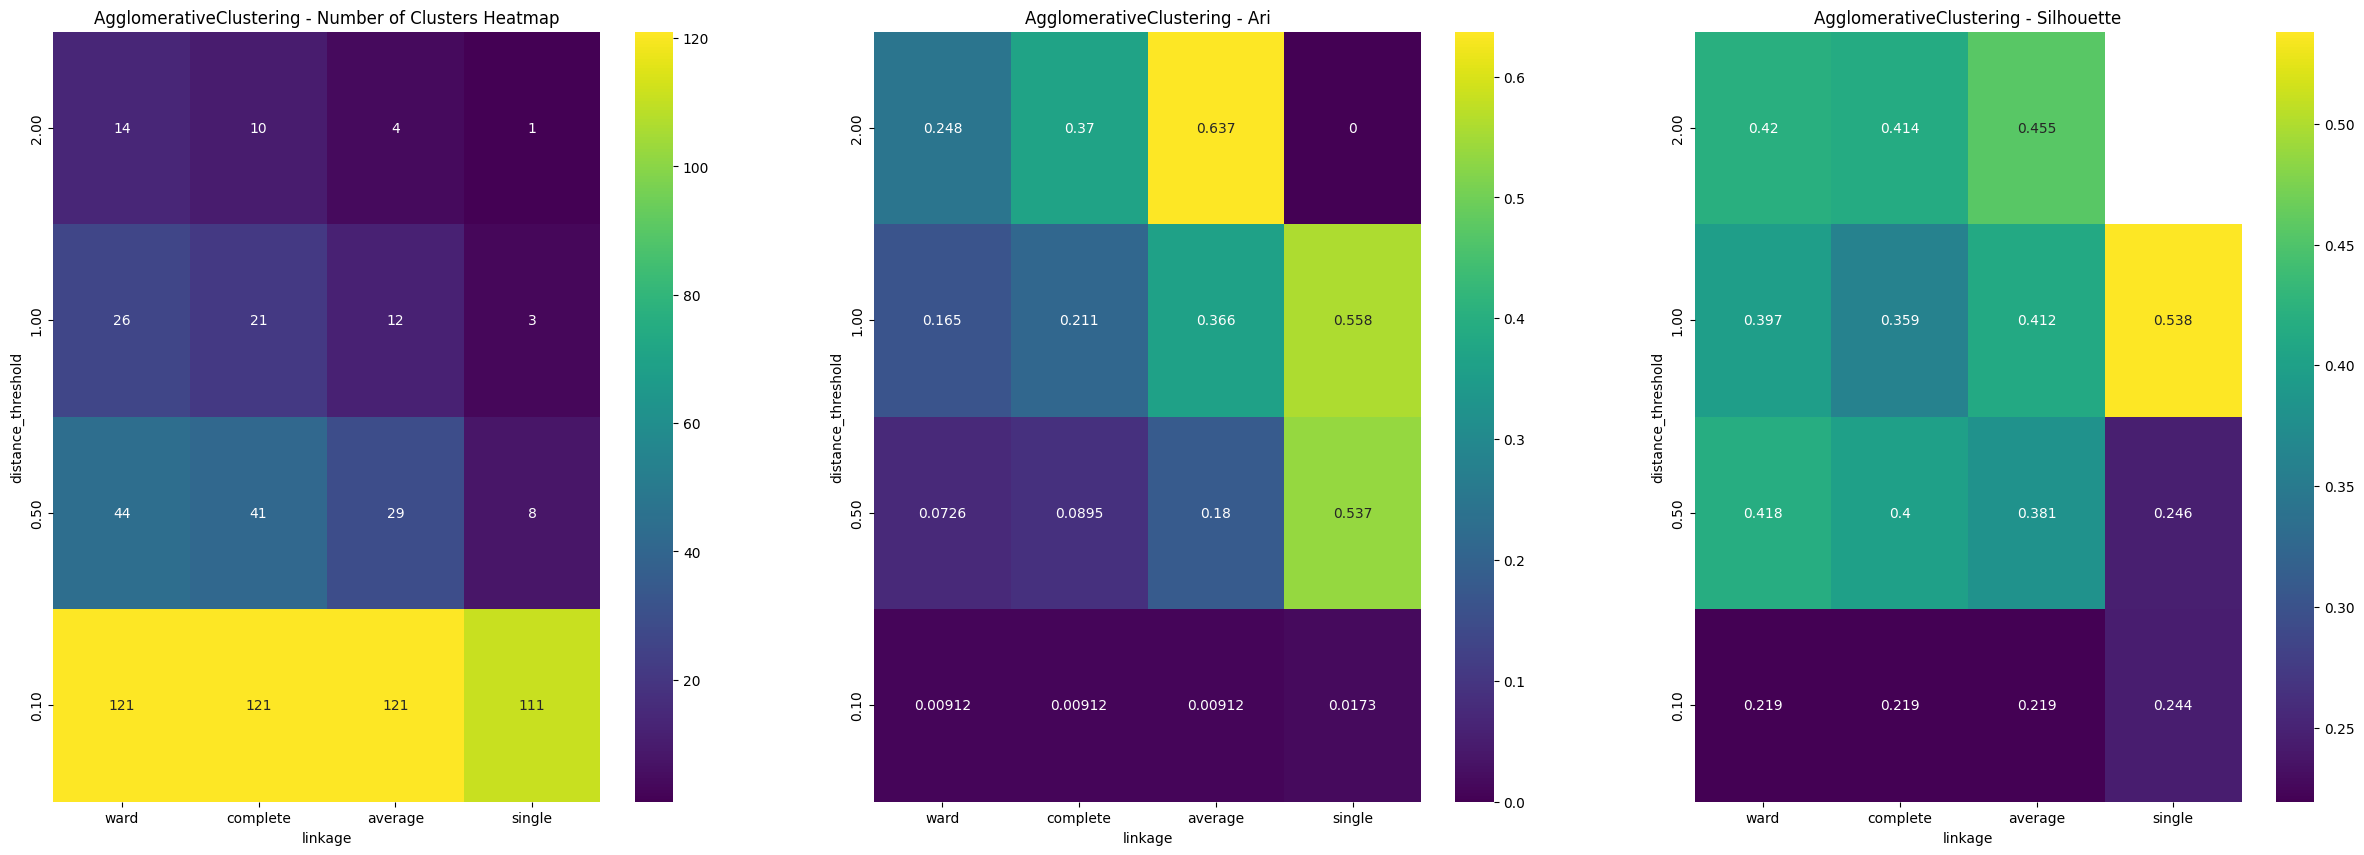

Processing AgglomerativeClustering


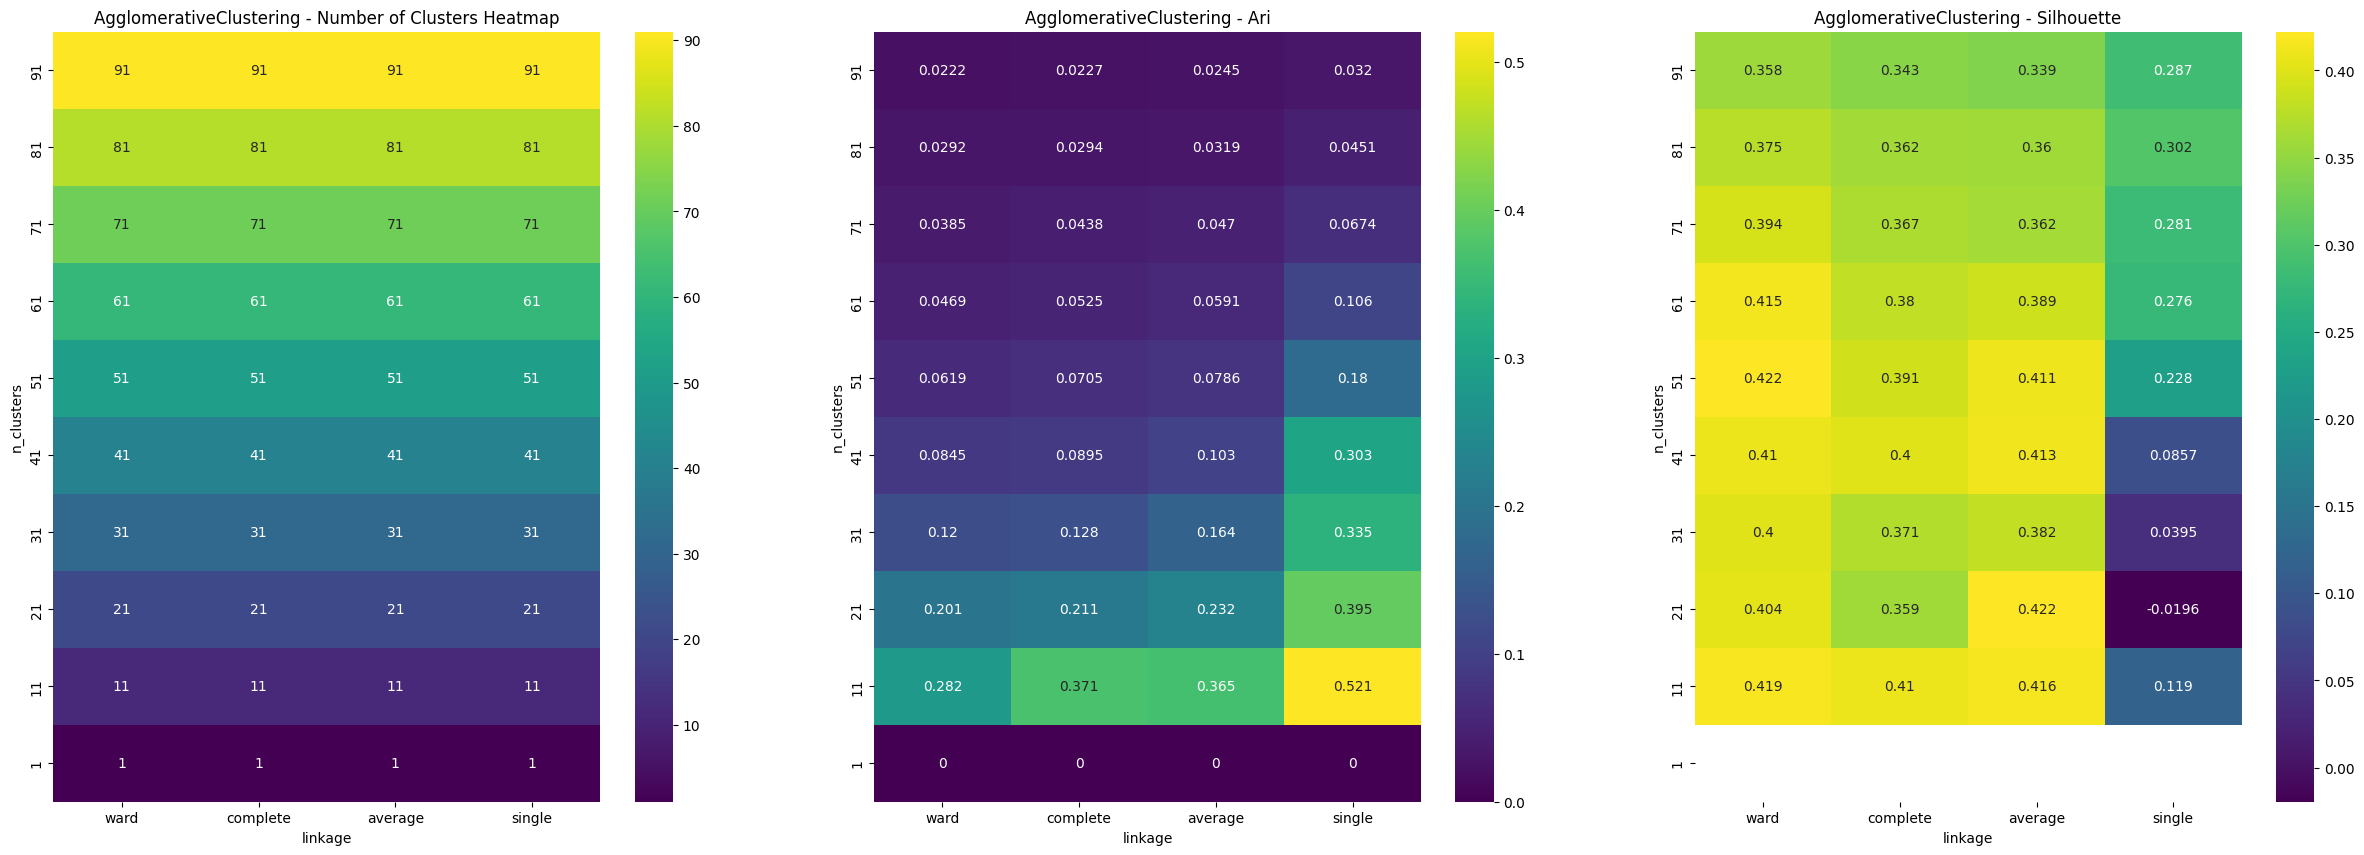

Processing OPTICS


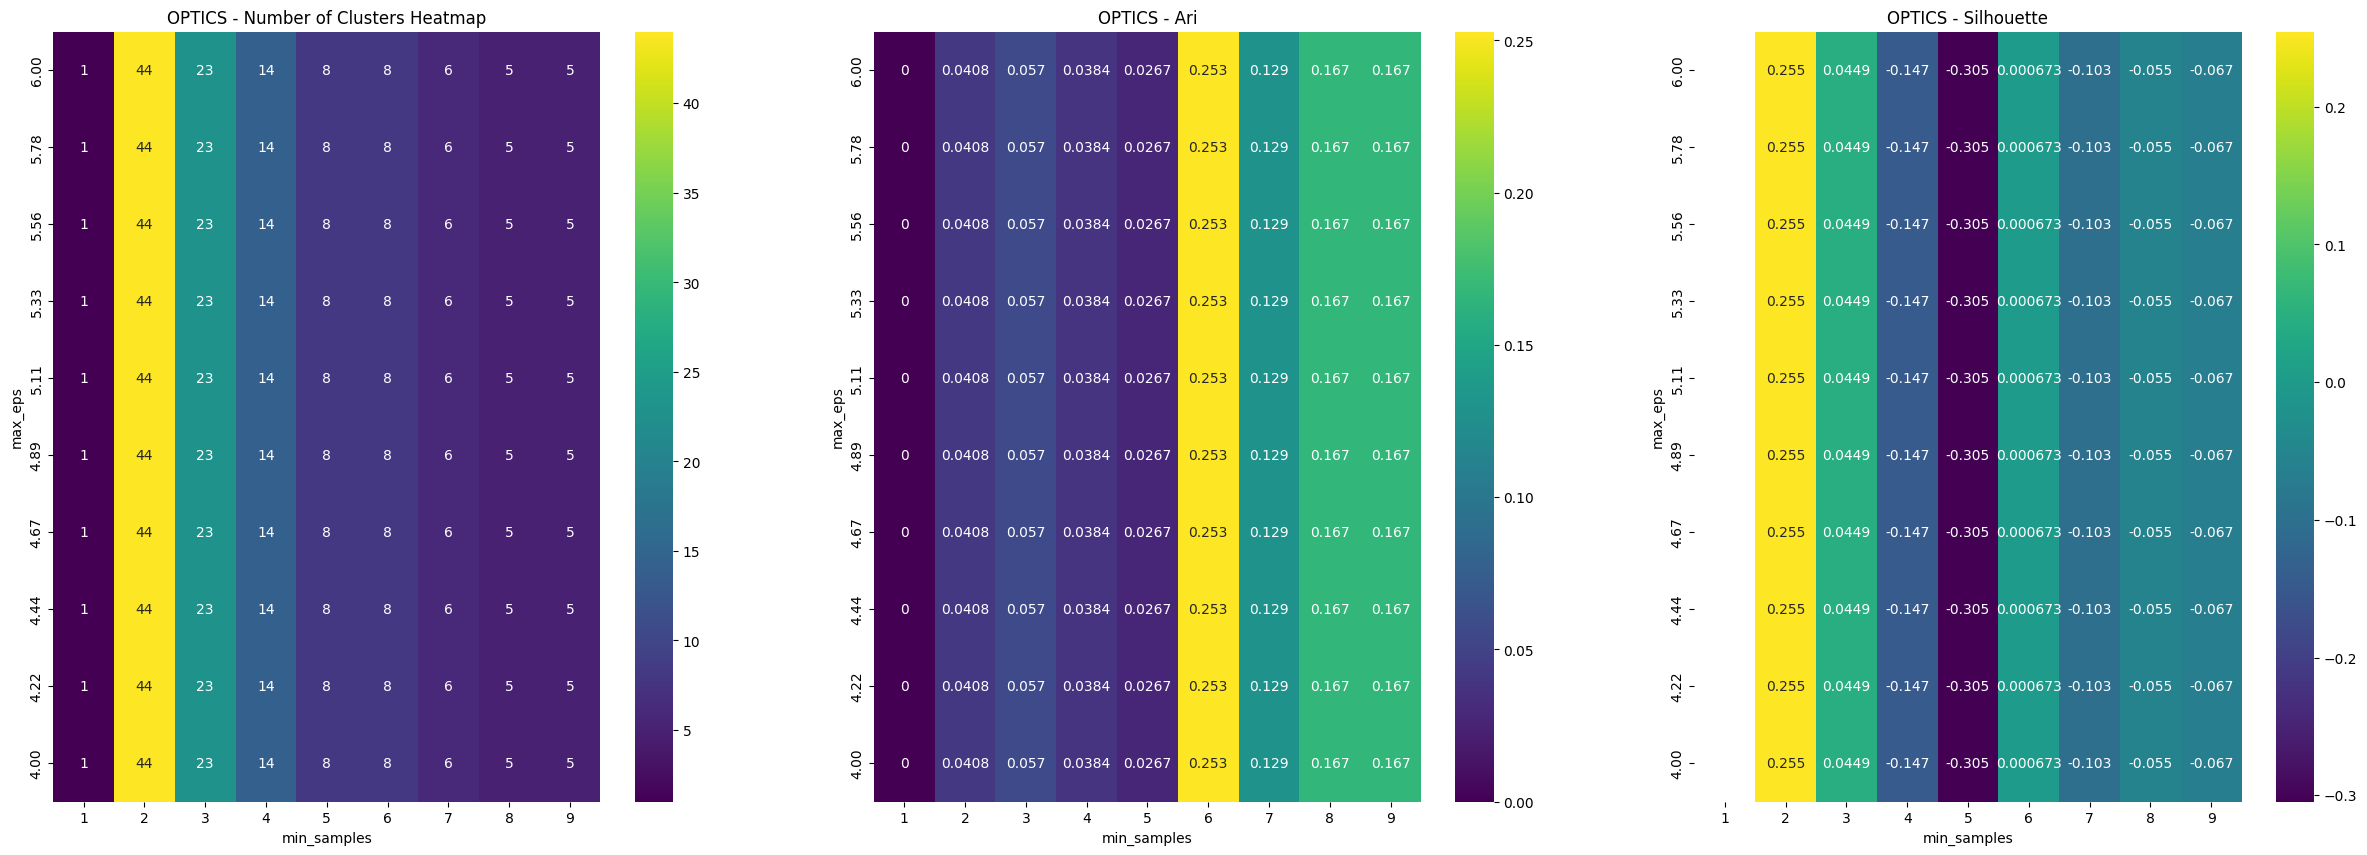

In [11]:
compare(X_pca)

Нарисуем зависимость количества кластеров от гиперпармаетров для данных спроецированных с помощью TSNE

Processing KMeans


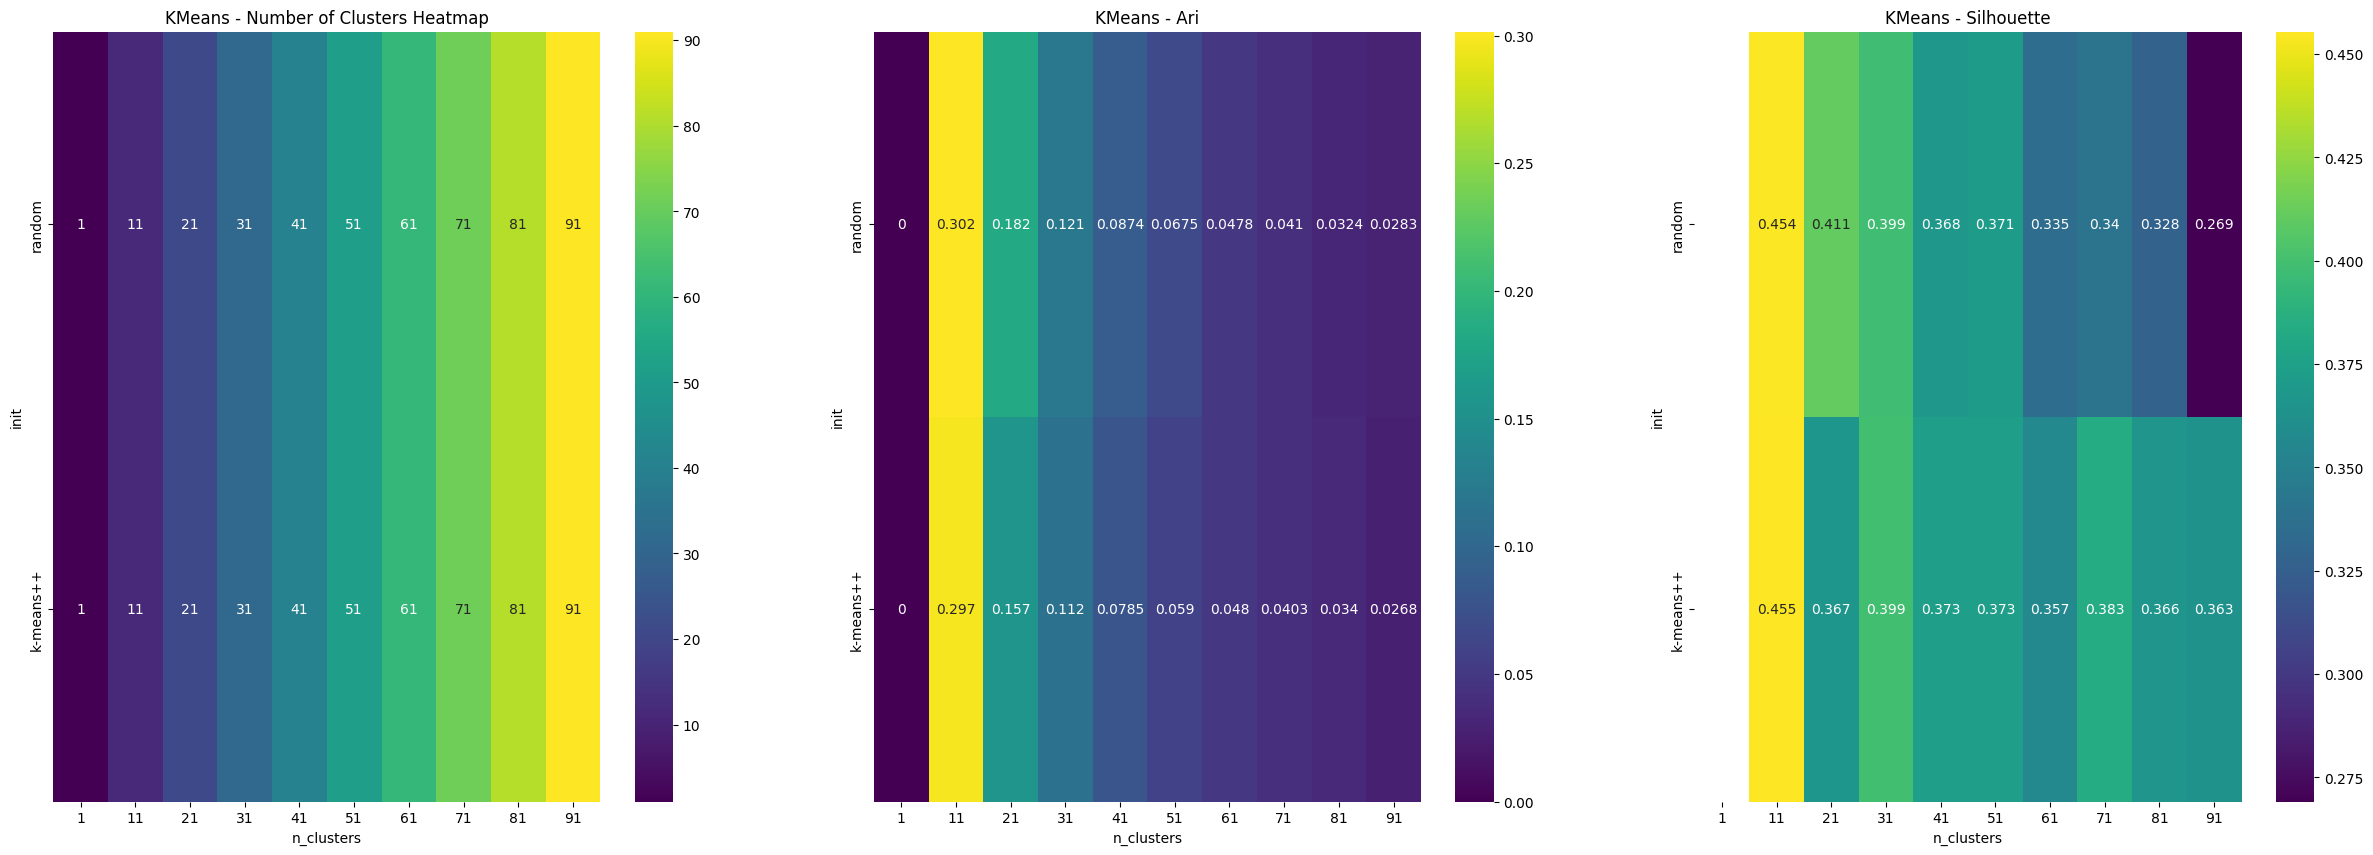

Processing AffinityPropagation


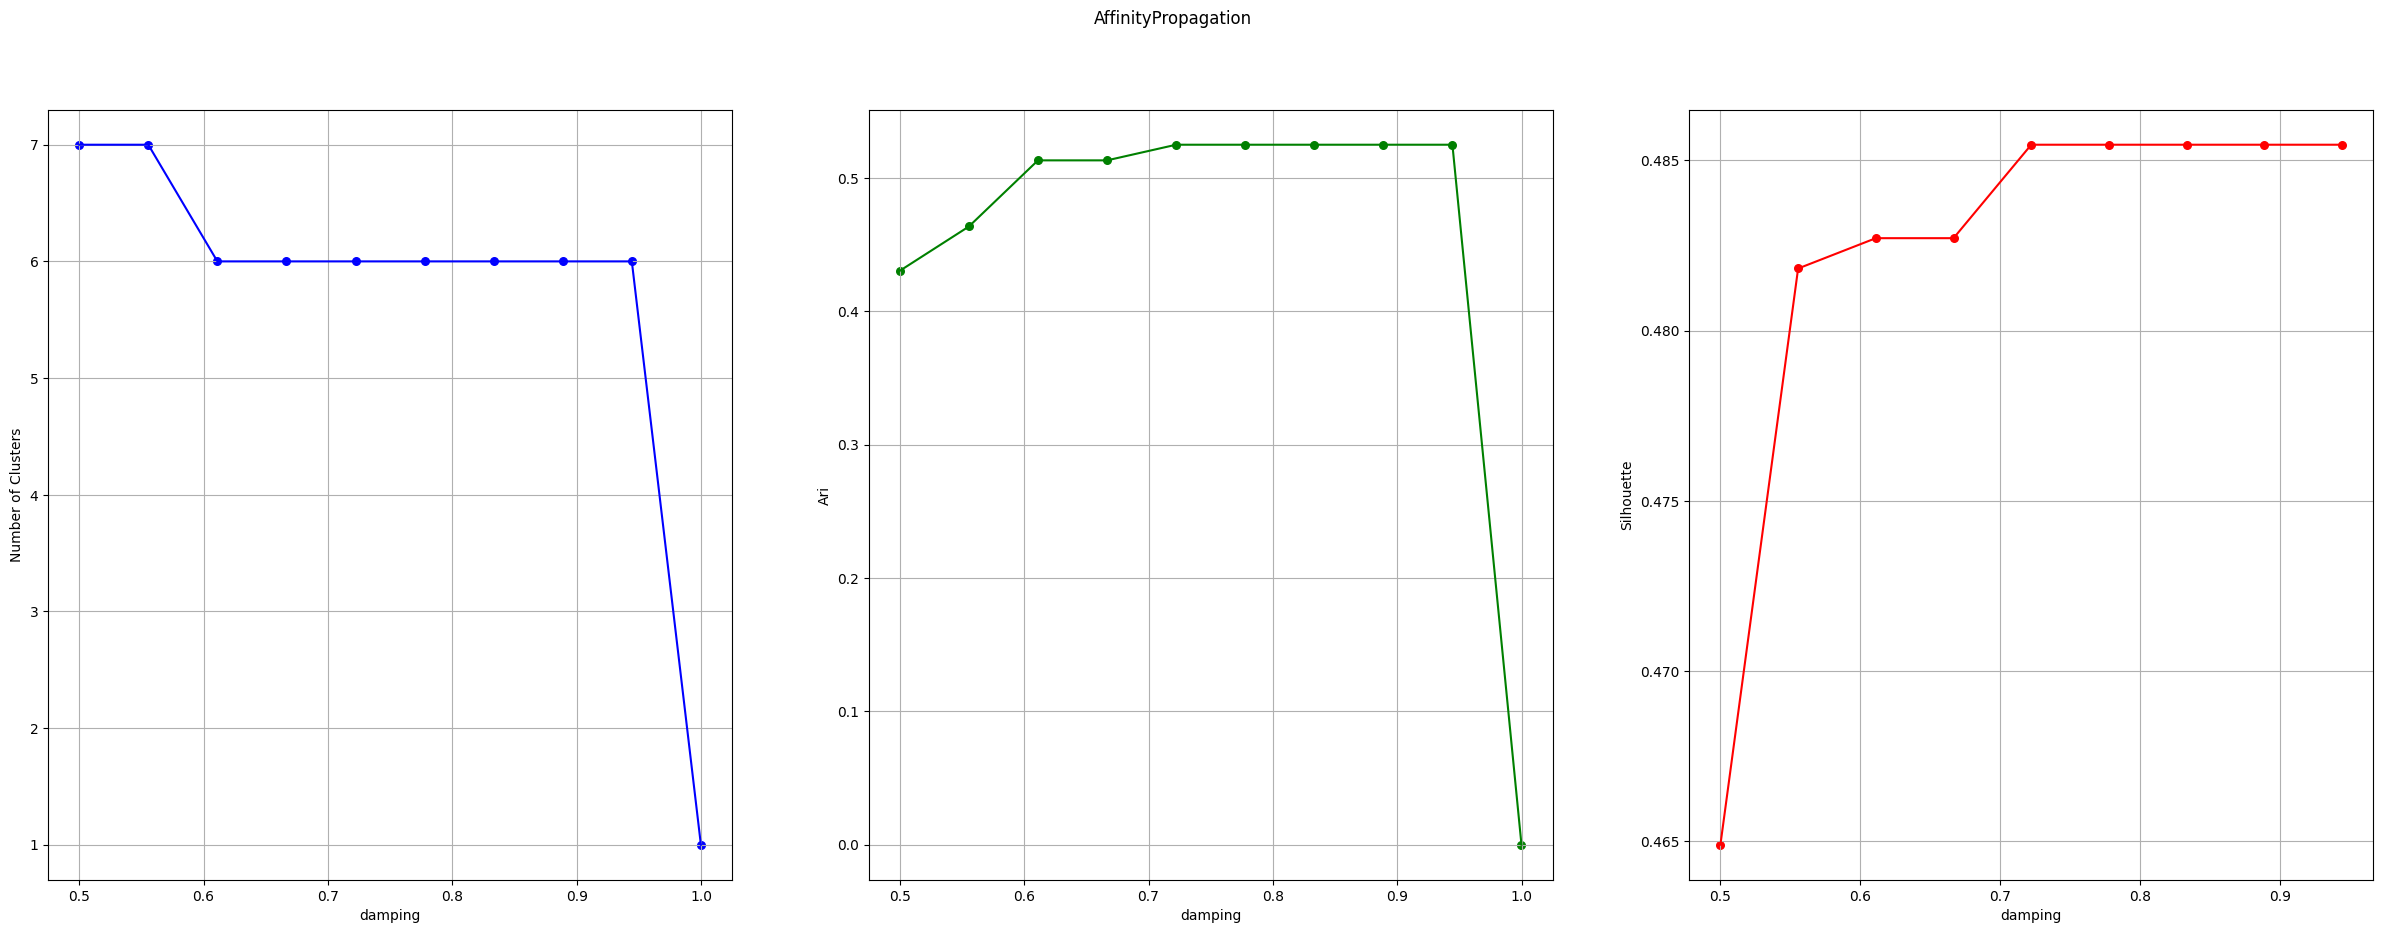

Processing AgglomerativeClustering


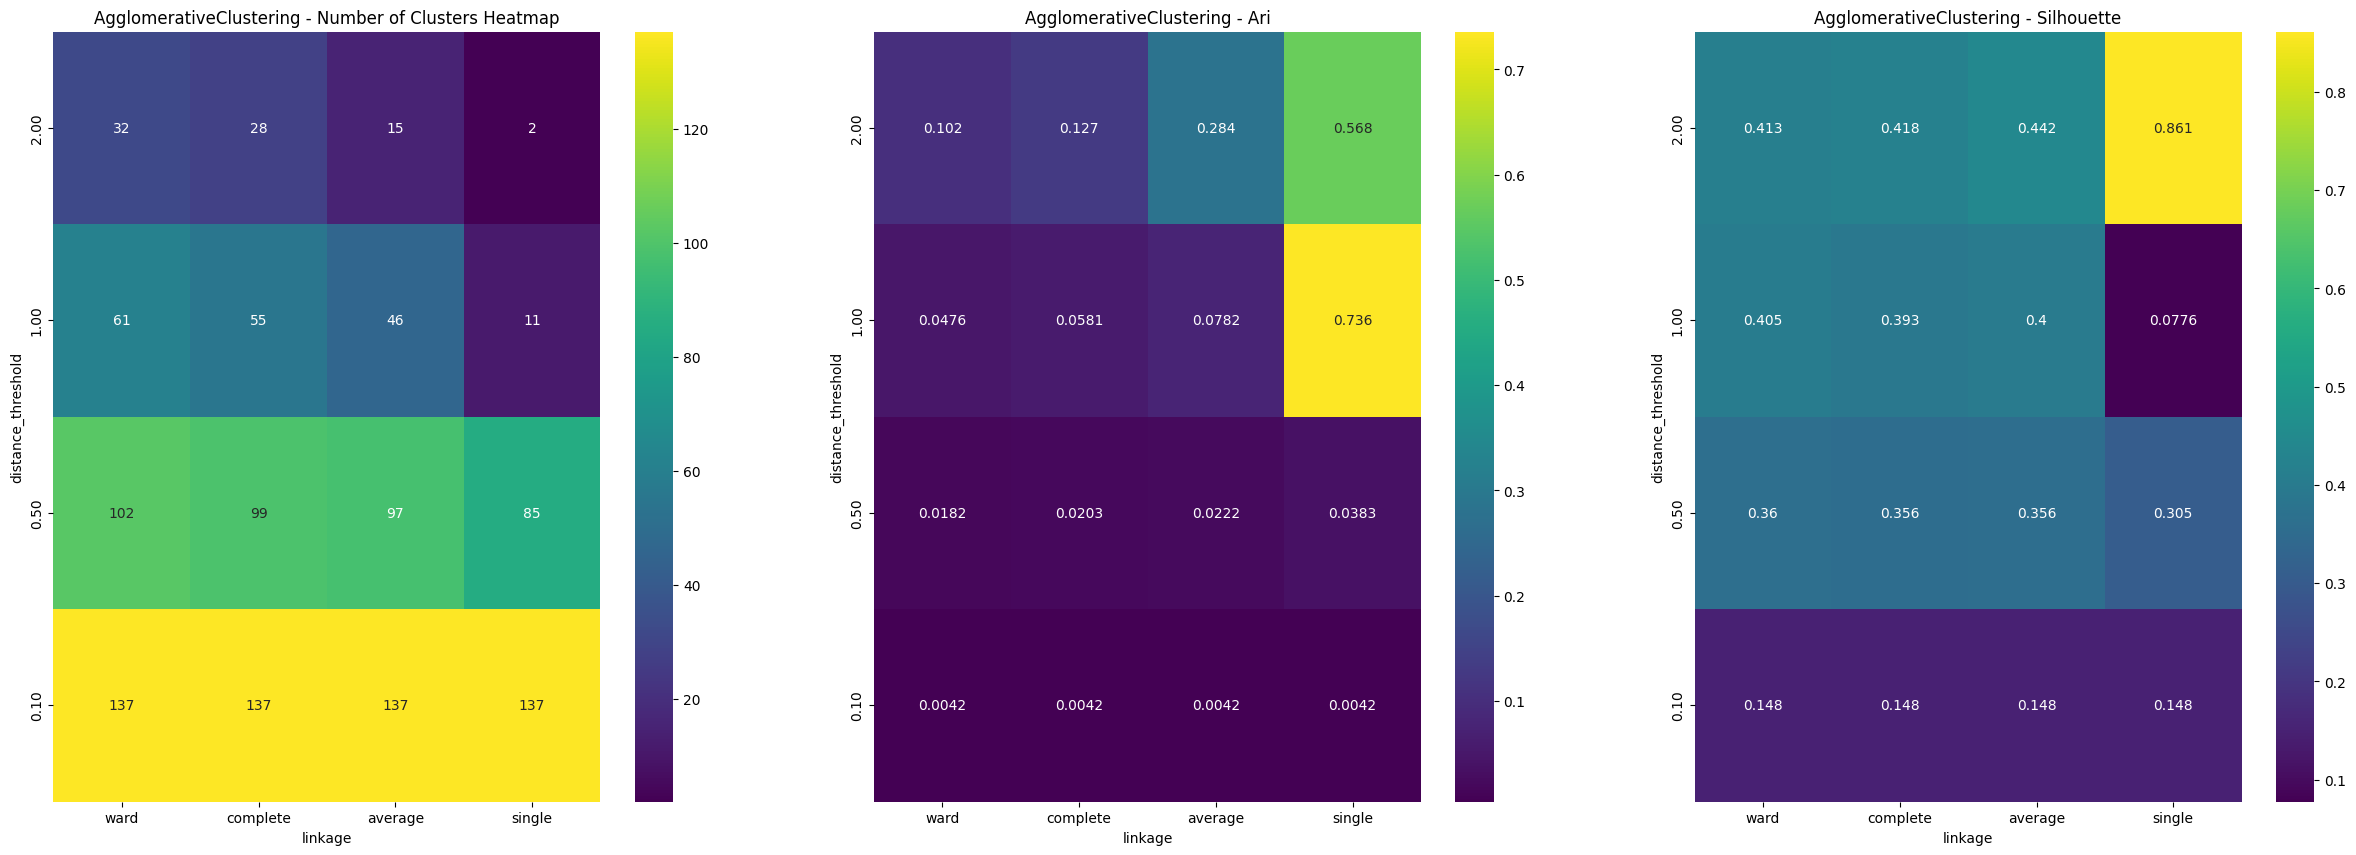

Processing AgglomerativeClustering


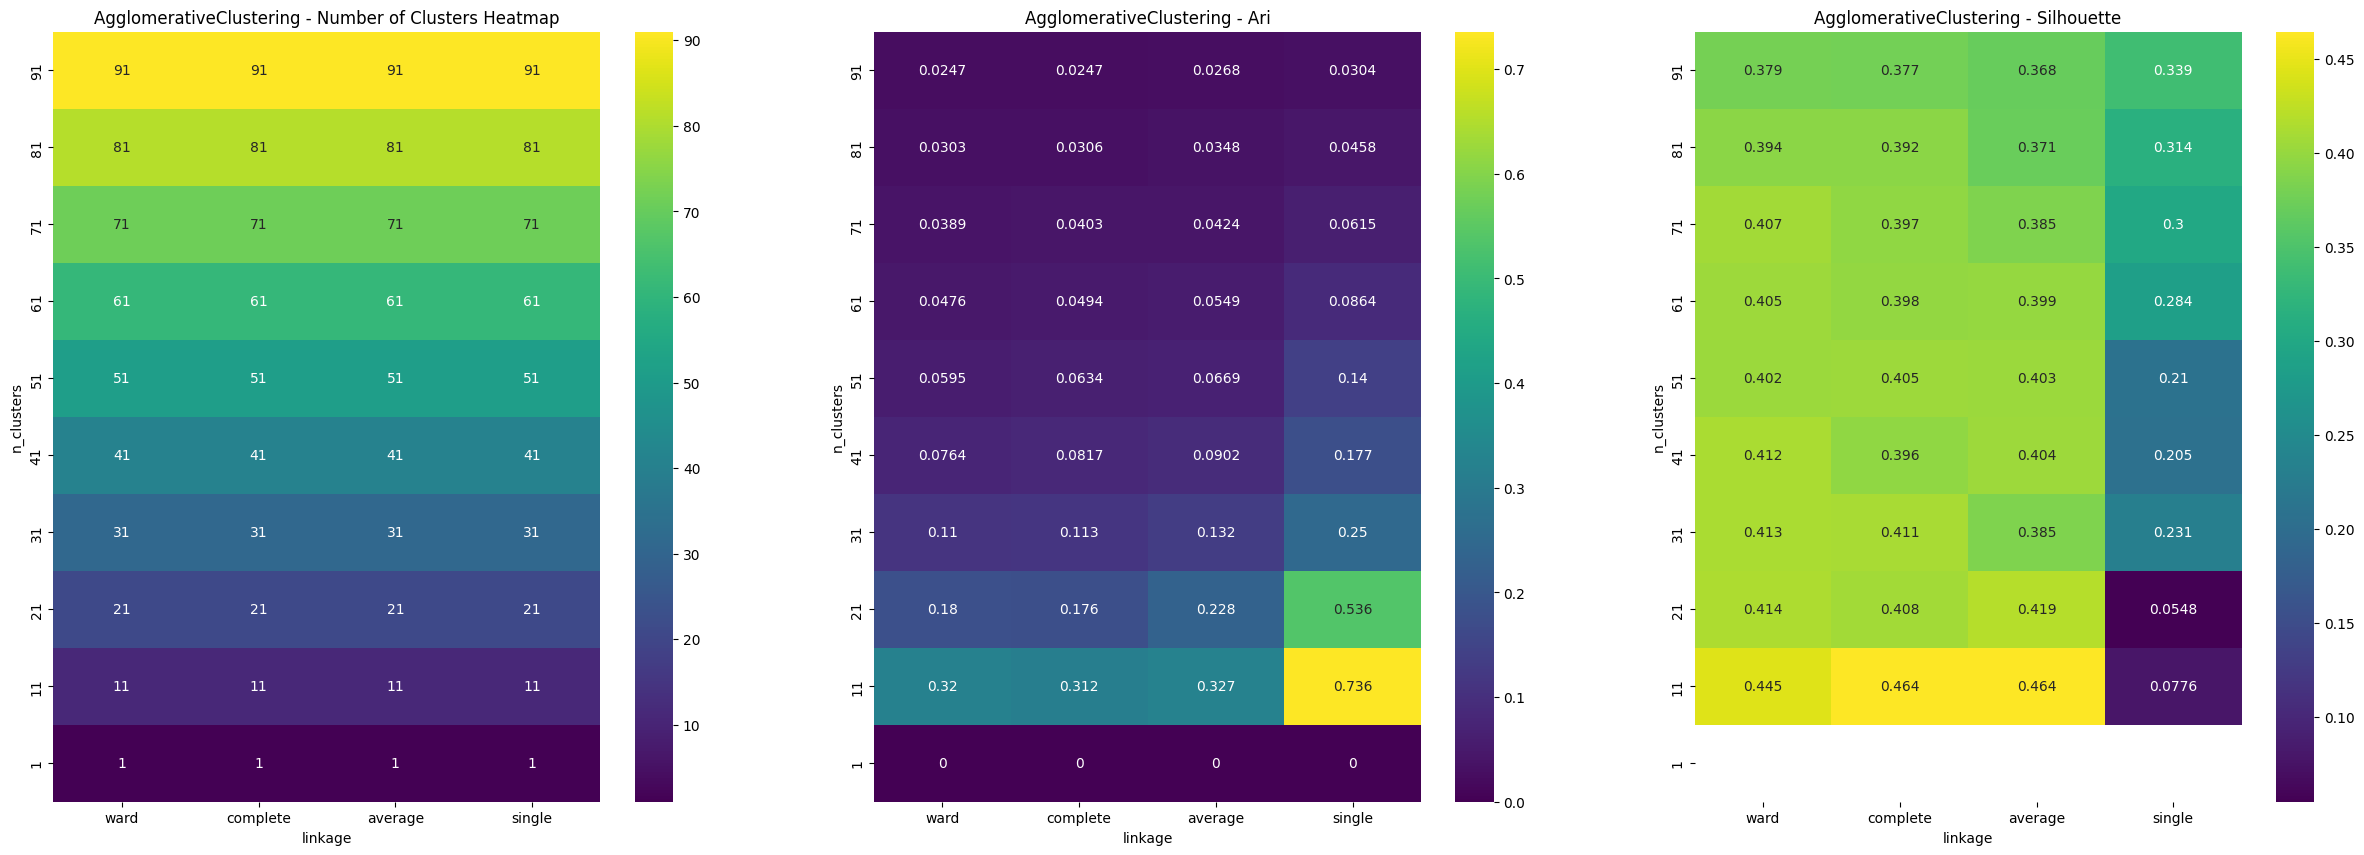

Processing OPTICS


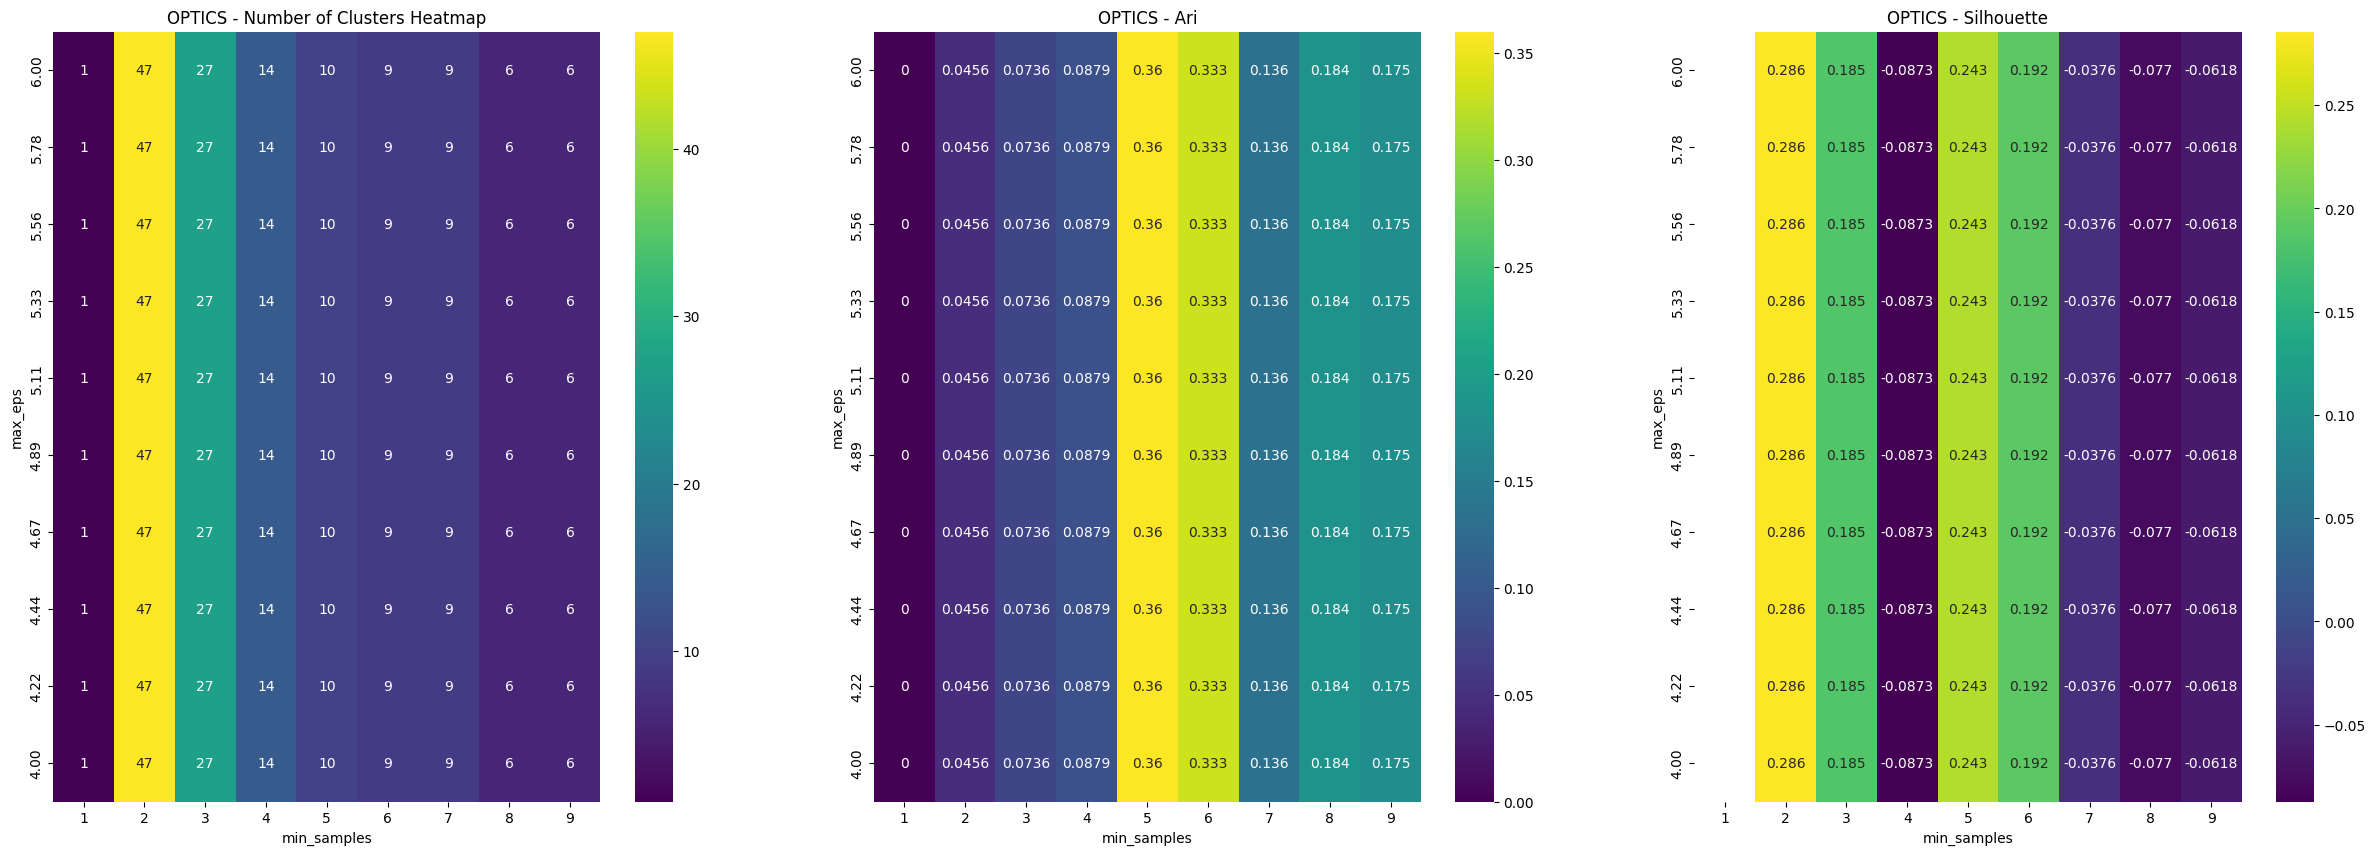

In [13]:
compare(X_tsne)

Нарисуем зависимость количества кластеров от гиперпармаетров для данных спроецированных с помощью UMAP

Processing KMeans


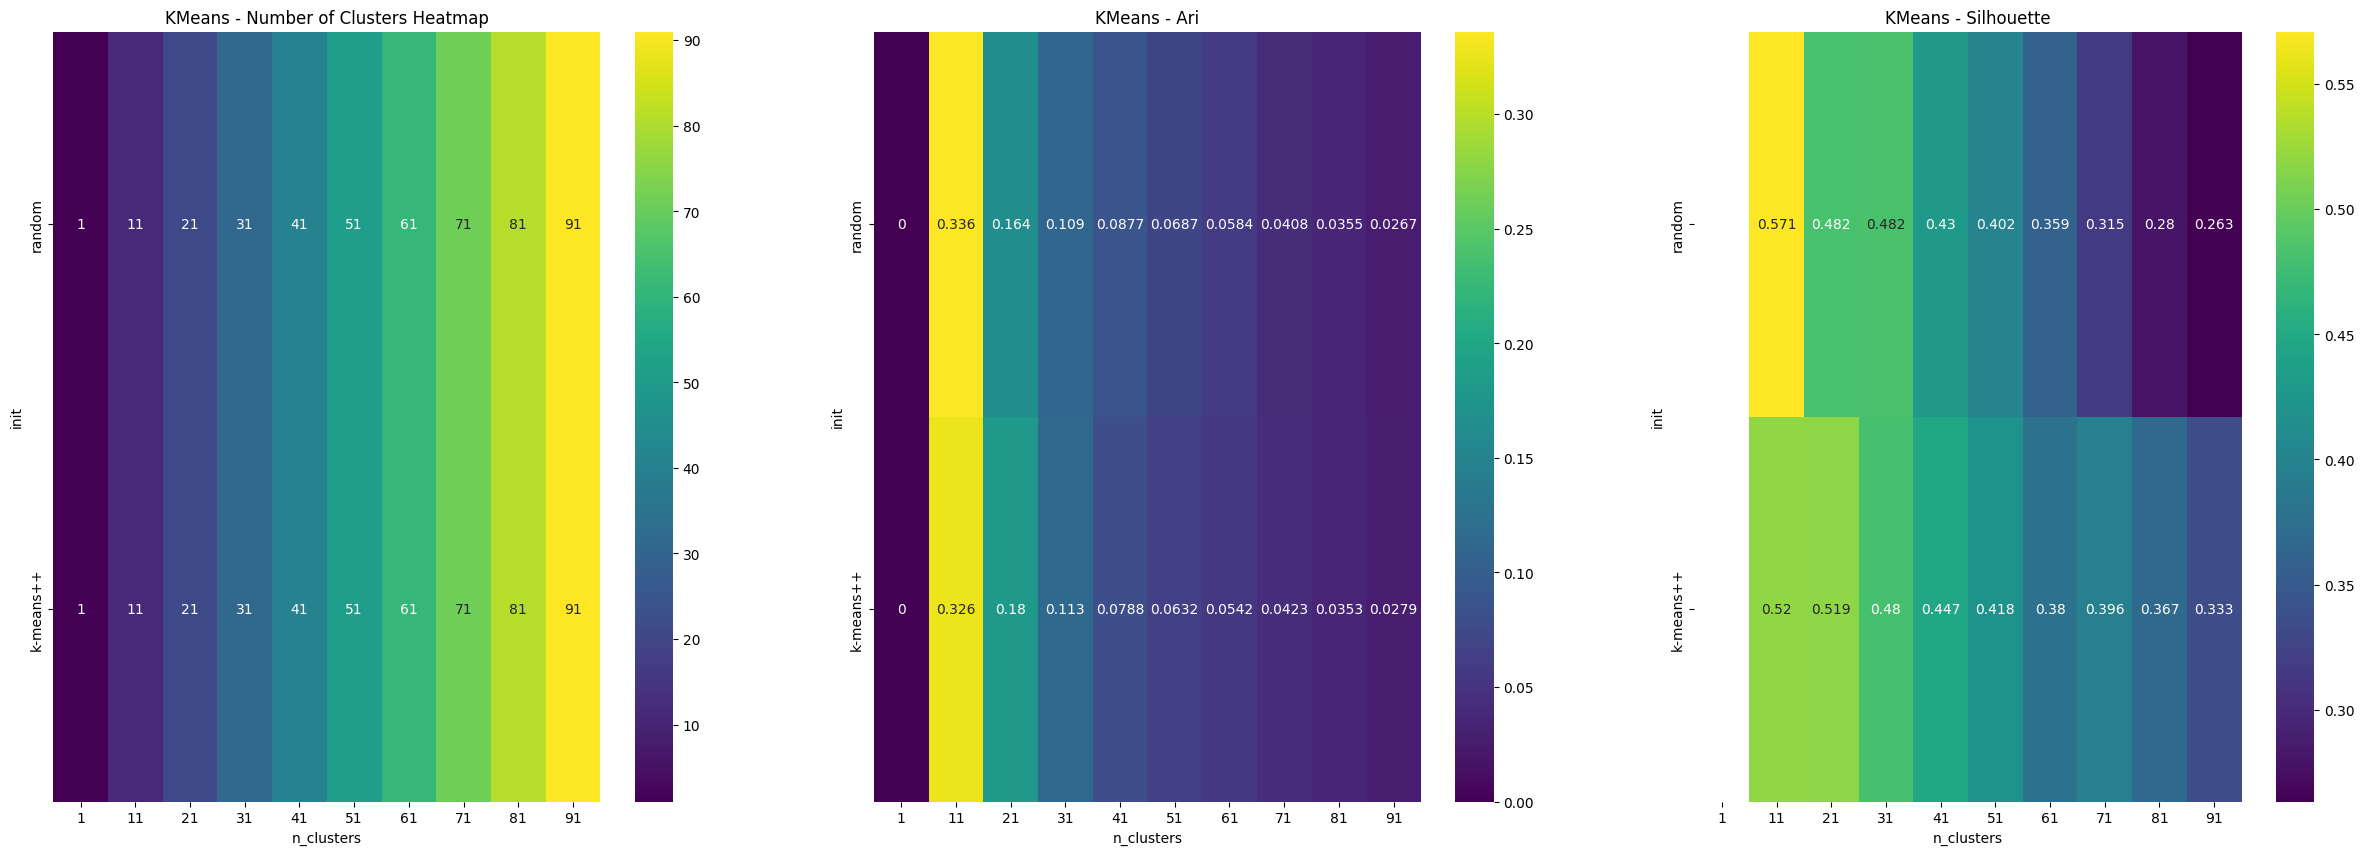

Processing AffinityPropagation


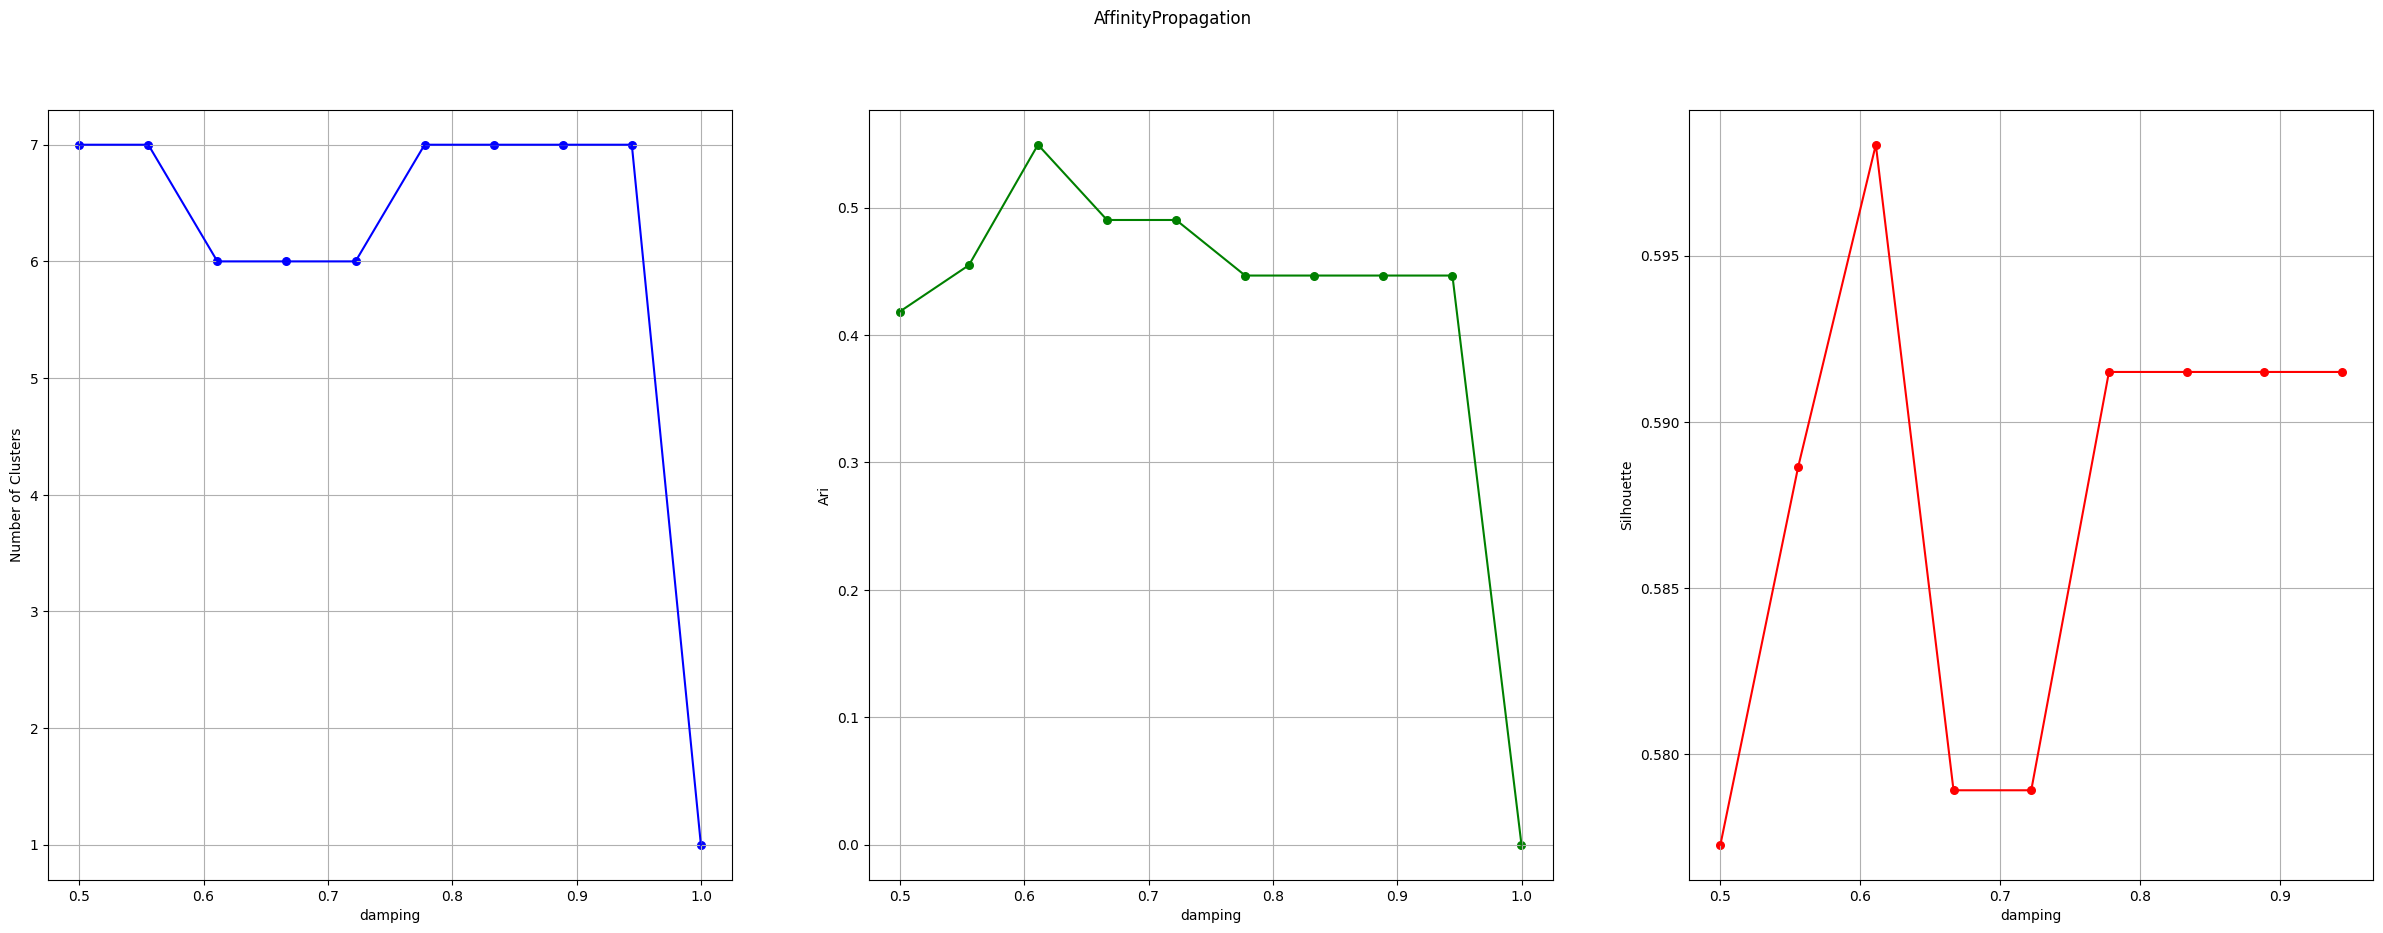

Processing AgglomerativeClustering


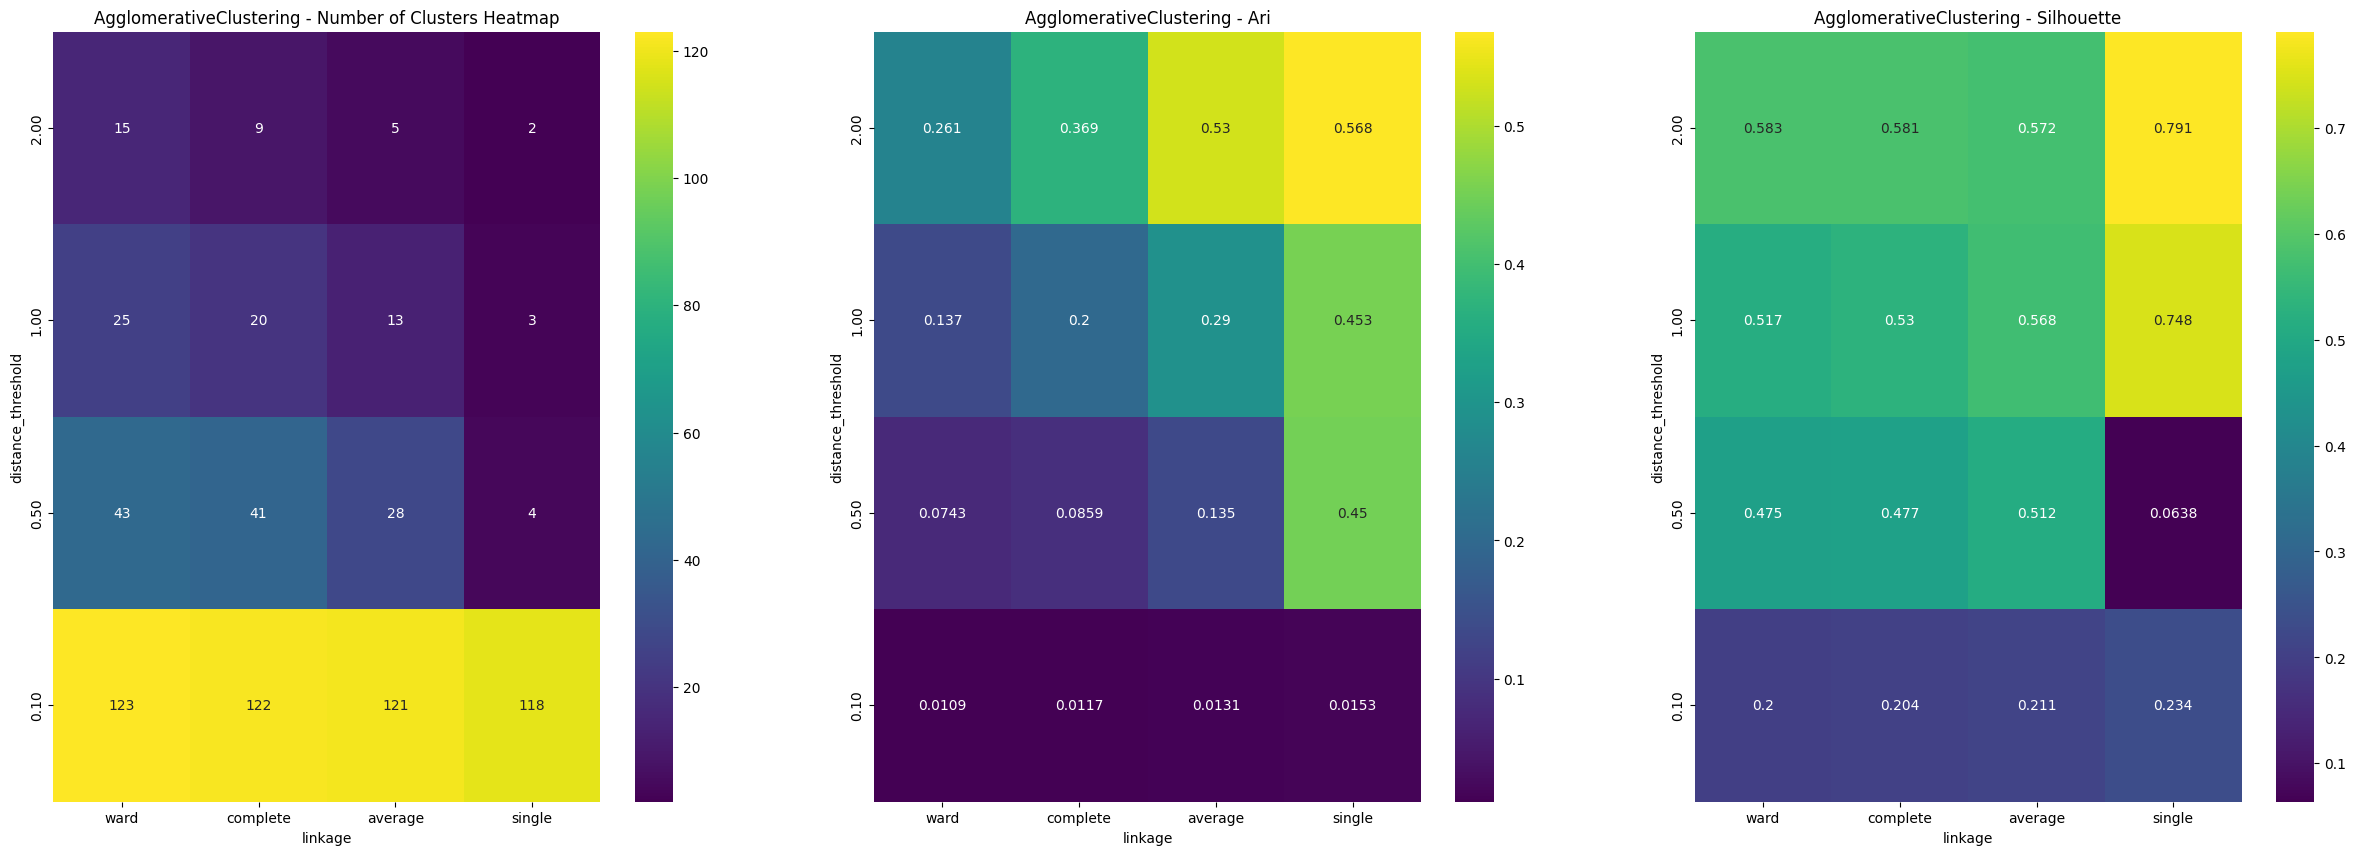

Processing AgglomerativeClustering


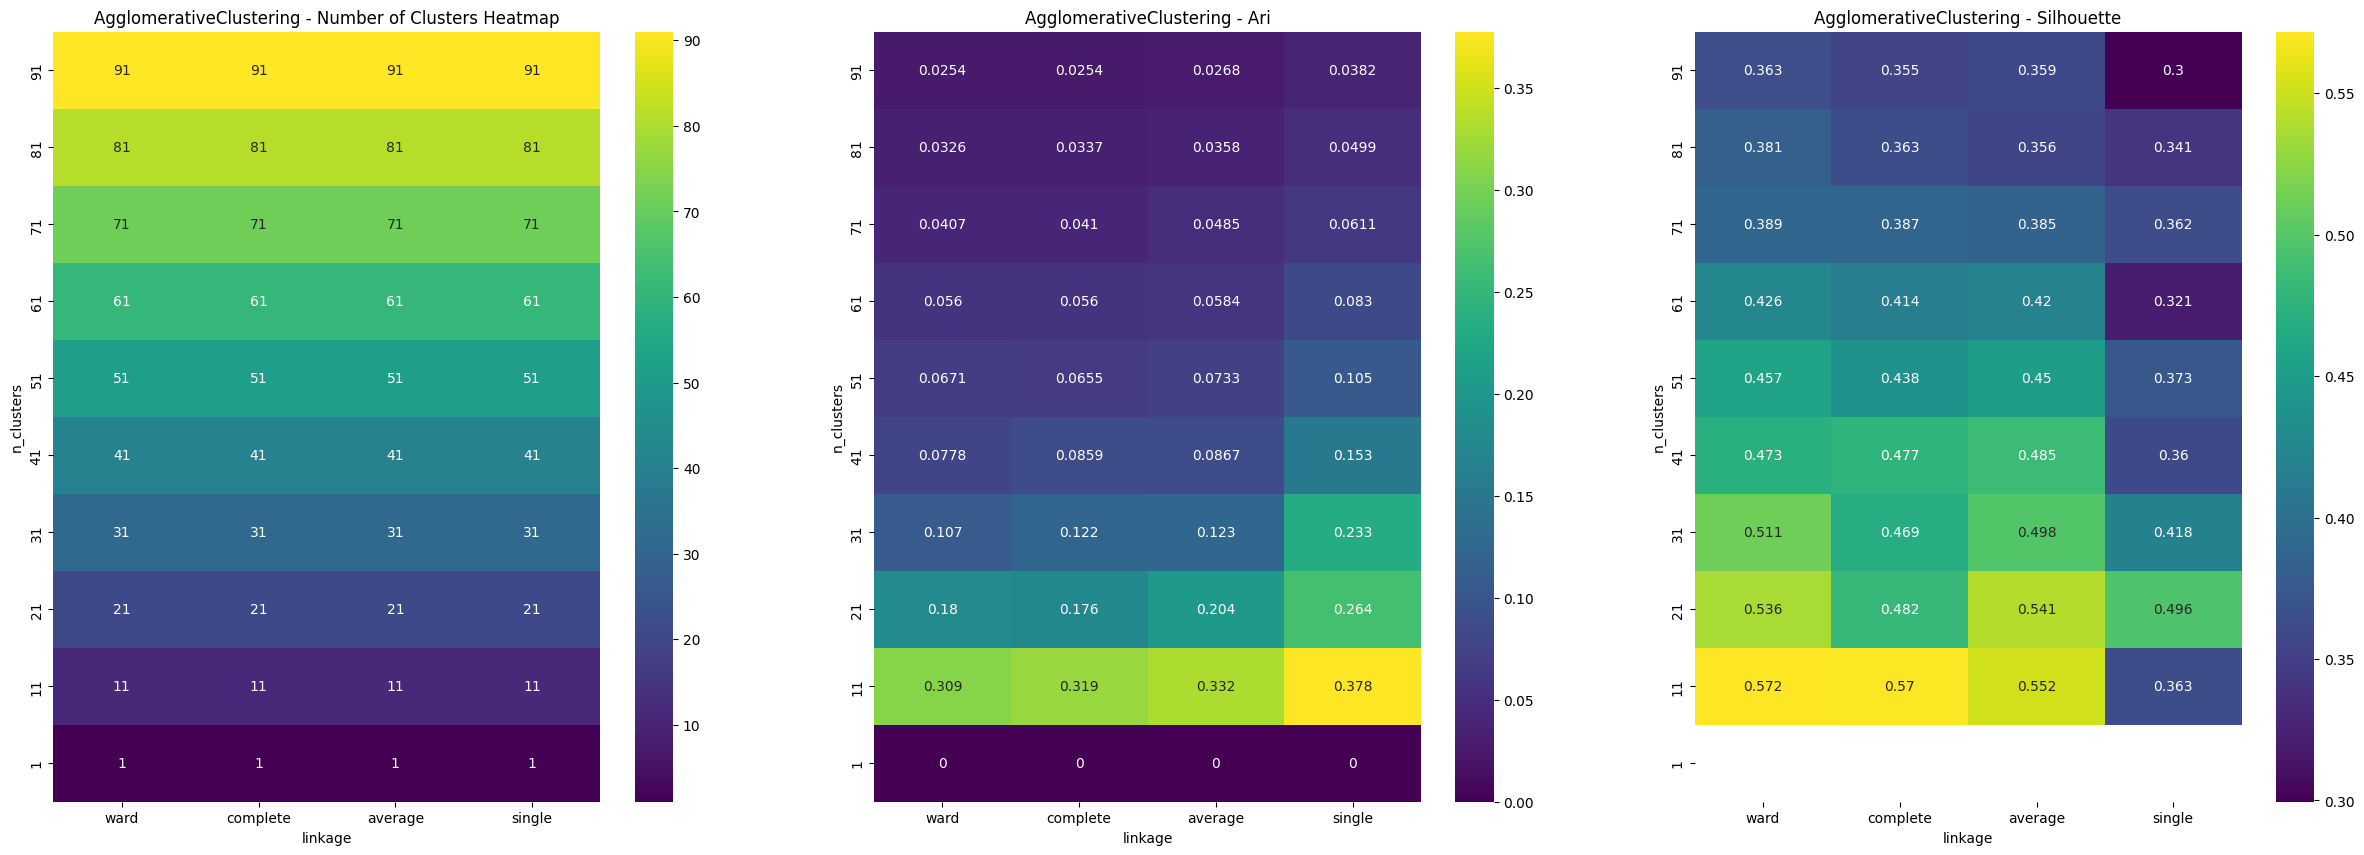

Processing OPTICS


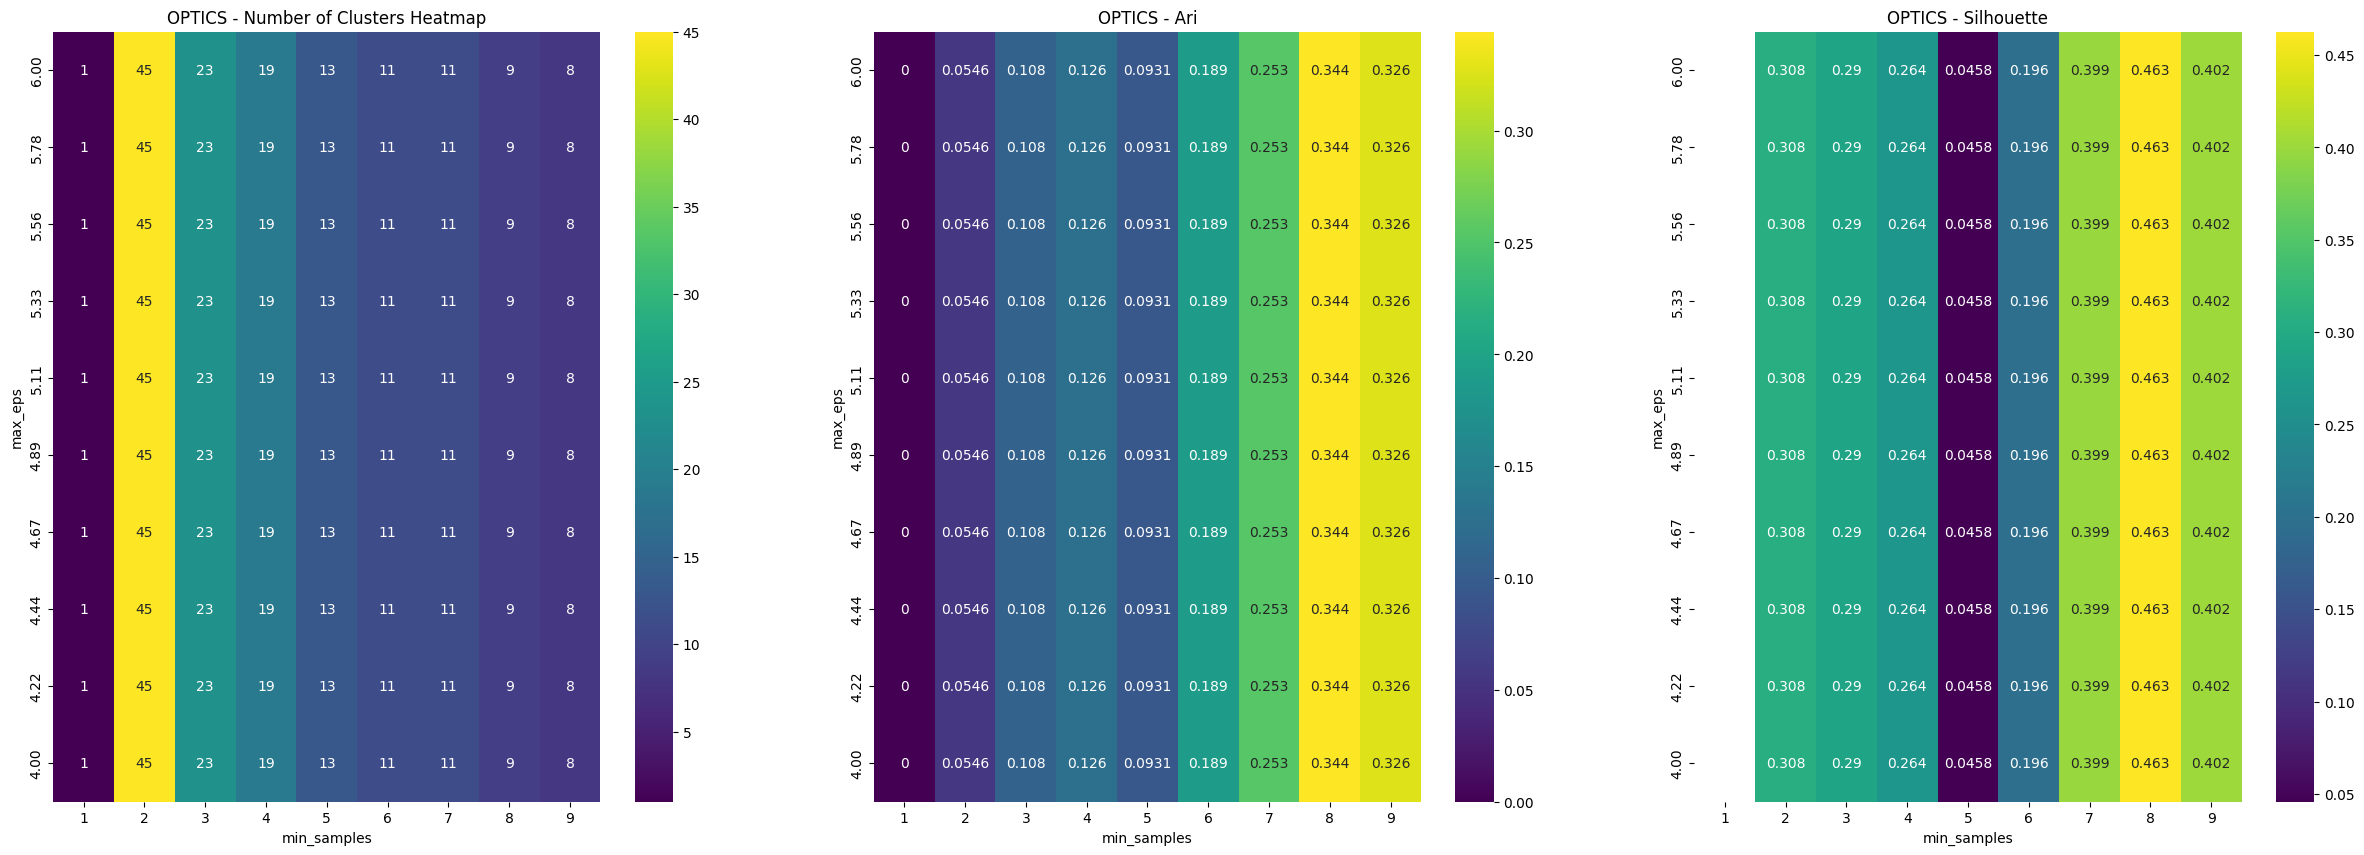

In [14]:
compare(X_umap)